<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/MLP_ISO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install torch
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset

# Google Colab Specific Imports
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
class SequenceDataset(Dataset):
    def __init__(self, df, feature_start_col='REP_Q2', feature_end_col='omega*', class_col='Class'):
        """
        Initializes the dataset by creating a list of sequences from the DataFrame.

        Parameters:
        - df: DataFrame containing clone_id, node features, and class labels.
        - feature_start_col: Column name indicating the start of the node feature columns.
        - feature_end_col: Column name indicating the end of the node feature columns.
        - class_col: Column name for the label. Defaults to 'Class'.
        """
        self.sequences = []

        # Group the DataFrame by clone_id
        for clone_id, group in df.groupby('ID'):
            # Extract node features and concatenate them into one sequence vector
            node_features = group.loc[:, feature_start_col:feature_end_col].values
            sequence_vector = torch.tensor(node_features.flatten(), dtype=torch.float)

            # Assign the mean label to the sequence
            label = torch.tensor(group[class_col].mean(), dtype=torch.float)

            # Append the sequence, label, and clone_id as a dictionary
            self.sequences.append({'sequence': sequence_vector, 'label': label, 'ID': clone_id})

    def __len__(self):
        # Return the number of sequences
        return len(self.sequences)

    def __getitem__(self, idx):
        # Retrieve a single sequence and its label
        data = self.sequences[idx]
        return data['sequence'], data['label'], data['ID']

Transformer Model For Binary Classification

In [30]:
class TransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_heads=8, num_layers=4, hidden_dim=128, dropout=0.1):
        super(TransformerBinaryClassifier, self).__init__()

        # Linear layer to project input features to the transformer dimension
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            dim_feedforward=hidden_dim * 6  # Increase feedforward dimension
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head with additional layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Embed input features
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, hidden_dim)

        # Ensure x has three dimensions
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Shape: (batch_size, 1, hidden_dim)

        # Permute for transformer input (transformer expects shape: [sequence_length, batch_size, hidden_dim])
        x = x.permute(1, 0, 2)

        # Pass through the transformer encoder
        x = self.transformer(x)

        # Permute back: (batch_size, sequence_length, hidden_dim)
        x = x.permute(1, 0, 2)

        # Use max pooling instead of mean pooling
        x = x.max(dim=1).values  # Shape: (batch_size, hidden_dim)

        # Classification head
        logits = self.classifier(x).squeeze(-1)  # Shape: (batch_size,)

        return logits

In [31]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.1):
        super(MLPBinaryClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.LayerNorm(dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def train_and_evaluate_model(dataset, device, model_class, num_epochs=10, batch_size=32, learning_rate=1e-4,
                             hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                             k_folds=5, augment_minority_class=False, weight_decay=0.0):

    # Retrieve input dimension from the first sample in the dataset
    first_sequence, _, _ = dataset[0]  # Adjust as needed to fit your dataset structure
    input_dim = first_sequence.shape[-1]

    # Cross-validation setup
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    best_val_accuracy = 0.0
    best_model_state = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"FOLD {fold + 1}/{k_folds}")
        if model_class == "TransformerBinaryClassifier":
          # Reinitialize the model for each fold
          model = model_class(
              input_dim=input_dim,
              num_heads=8,
              num_layers=4,
              hidden_dims=hidden_dim,
              dropout=0.1
          ).to(device)
          #Reinitialize the model for each fold
        else:
          # simple MLP model
          model = model_class(
              input_dim=input_dim,
              hidden_dims=[128, 64, 32],  # Adjust the hidden layer sizes as desired
              dropout=0.1
          ).to(device)

        # Create train and validation subsets
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        print(val_subset)

        # Augment Class 1 samples in the training set if specified
        if augment_minority_class:
            class_1_indices = [i for i in train_idx if dataset[i][1] == 1]
            class_1_subset = Subset(dataset, class_1_indices)
            train_subset = ConcatDataset([train_subset, class_1_subset])

        # DataLoaders for train and validation subsets
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize loss function and optimizer with weight decay
        criterion = nn.BCELoss(reduction='none')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Initialize the learning rate scheduler
        #scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

        # Training loop for each epoch
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        for epoch in range(num_epochs):
            model.train()
            train_loss, correct_train, total_train = 0, 0, 0

            for batch in train_loader:
                sequences, labels, _ = batch
                sequences = sequences.to(device)
                labels = labels.to(device)

                # Create a weight tensor for each sample in the batch
                weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)

                # Forward pass
                logits = model(sequences).squeeze(dim=1)
                loss_per_sample = criterion(logits, labels.float())
                loss = (loss_per_sample * weight).mean()

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate training loss and accuracy
                train_loss += loss.item() * sequences.size(0)
                preds = (logits > 0.5).float()
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            train_losses.append(train_loss / total_train)
            train_accuracies.append(correct_train / total_train)

            # Validation loop
            model.eval()
            val_loss, correct_val, total_val = 0, 0, 0
            val_labels, val_preds = [], []
            repressor_ids = [] # List to store the IDs of repressors
            with torch.no_grad():
                for batch in val_loader:
                    sequences, labels, ids = batch
                    sequences = sequences.to(device)
                    labels = labels.to(device)

                    logits = model(sequences).squeeze()
                    #loss_per_sample = criterion(logits, labels.float())
                    loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                    predictions = (logits > 0.5).float()
                    correct_val += (predictions == labels).sum().item()
                    total_val += labels.size(0)
                    val_labels.extend(labels.cpu().numpy())
                    val_preds.extend(predictions.cpu().numpy())
                    # Capture IDs of repressors
                    for i, label in enumerate(labels):
                        if label == 0:  # Assuming 0 indicates a repressor
                            repressor_ids.append(ids[i])  # Collect the repressor ID

            print(f"Repressor IDs in Fold {fold + 1}: {repressor_ids}")
            val_losses.append(val_loss / total_val)
            val_accuracies.append(correct_val / total_val)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

            # Step the scheduler at the end of each epoch
            #scheduler.step()

        # Check if this fold has the best validation accuracy
        if val_accuracies[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracies[-1]
            best_model_state = model.state_dict()  # Save the model's weights

        # Plot confusion matrix for this fold
        cm = confusion_matrix(val_labels, val_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
        disp.plot(cmap="Blues")
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.show()

        # Save results for the current fold
        results.append({
            'Fold': fold + 1,
            'Validation Accuracy': val_accuracies[-1],
            'Validation Loss': val_losses[-1]
        })

    avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
    print(f"\nAverage Validation Accuracy: {avg_accuracy:.4f}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

    # Return the best model's state along with other results
    return best_model_state, train_losses, val_losses, train_accuracies, val_accuracies, avg_accuracy


Get Data

In [34]:
# Import data from both the isoform data and Bintu dataset
# Bintu dataset
# Train on the whole Dataset
data = '/content/drive/My Drive/Disorder/Input_data/BINTU_FULL.csv'
df = pd.read_csv(data)
df = df.iloc[:,1:]
start = "REP_Q2"
end = "omega*"
# Initialize the dataset with the cleaned DataFrame
dataset = SequenceDataset(df, feature_start_col='REP_Q2', feature_end_col='omega*', class_col='Class')
# Define a DataLoader to iterate over the dataset in batches
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #Model handles this

# Kaia datset
# Train on the whole Dataset
data_iso = '/content/drive/My Drive/Disorder/Input_data/ISO_FULL.CSV'
df_iso = pd.read_csv(data_iso)
#df = df.iloc[:,1:]
start = "REP_Q2"
end = "omega*"
# Initialize the dataset with the cleaned DataFrame
dataset_iso = SequenceDataset(df_iso, feature_start_col='REP_Q2', feature_end_col='omega*', class_col='Class')
# Define a DataLoader to iterate over the dataset in batches

In [44]:
for batch in dataloader_iso:
    features, labels, ids = batch  # Unpack the batch
    for id in ids:
        print(id)  # Print each ID
    break  # Remove this break if you want to print IDs for all batches


ELF2-1
ESR2-3
NR4A2-1
TBX5-2
ZNF264-2
MSX2-1
ZNF143-1
ZSCAN18-2
TFCP2-2
ZNF143-3
SPIB-1
NFYA-2
DMTF1-2
TFCP2-3
ZNF451-7
ESR2-2
STAT1-5
NFIX-4
STAT5A-1
ZNF451-8
OSR2-2
FOXP3-3
TCF4-7
FOSB-3
WT1-6
LEF1-3
TBPL1-1
PKNOX1-4
ZBTB44-5
SP2-3
ELK4-1
PAX7-4


Train model on TF isoform dataset

FOLD 1/5
Repressor IDs in Fold 1: ['ESR2-3', 'OSR2-1', 'ZBTB44-3', 'ZNF26-1', 'ZNF430-3', 'ZNF544-1', 'ZNF544-2']
Epoch [1/100], Train Loss: 0.3443, Val Loss: 0.2926, Train Acc: 0.8125, Val Acc: 0.8841
Repressor IDs in Fold 1: ['ESR2-3', 'OSR2-1', 'ZBTB44-3', 'ZNF26-1', 'ZNF430-3', 'ZNF544-1', 'ZNF544-2']
Epoch [2/100], Train Loss: 0.3213, Val Loss: 0.2736, Train Acc: 0.8382, Val Acc: 0.8986
Repressor IDs in Fold 1: ['ESR2-3', 'OSR2-1', 'ZBTB44-3', 'ZNF26-1', 'ZNF430-3', 'ZNF544-1', 'ZNF544-2']
Epoch [3/100], Train Loss: 0.3062, Val Loss: 0.2611, Train Acc: 0.8529, Val Acc: 0.8986
Repressor IDs in Fold 1: ['ESR2-3', 'OSR2-1', 'ZBTB44-3', 'ZNF26-1', 'ZNF430-3', 'ZNF544-1', 'ZNF544-2']
Epoch [4/100], Train Loss: 0.3032, Val Loss: 0.2517, Train Acc: 0.8566, Val Acc: 0.8986
Repressor IDs in Fold 1: ['ESR2-3', 'OSR2-1', 'ZBTB44-3', 'ZNF26-1', 'ZNF430-3', 'ZNF544-1', 'ZNF544-2']
Epoch [5/100], Train Loss: 0.2793, Val Loss: 0.2474, Train Acc: 0.8676, Val Acc: 0.8986
Repressor IDs in Fold 1: [

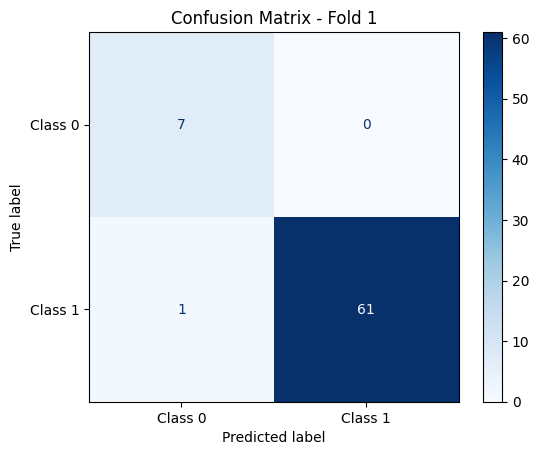

FOLD 2/5
Repressor IDs in Fold 2: ['FOXP3-3', 'MAX-4', 'MAX-5', 'MAX-6', 'OSR2-2', 'RFX4-2', 'ZBTB44-5', 'ZNF169-4', 'ZNF230-1', 'ZNF397-4', 'ZNF415-2', 'ZNF430-2', 'ZNF548-1']
Epoch [1/100], Train Loss: 0.3685, Val Loss: 0.4037, Train Acc: 0.6740, Val Acc: 0.7059
Repressor IDs in Fold 2: ['FOXP3-3', 'MAX-4', 'MAX-5', 'MAX-6', 'OSR2-2', 'RFX4-2', 'ZBTB44-5', 'ZNF169-4', 'ZNF230-1', 'ZNF397-4', 'ZNF415-2', 'ZNF430-2', 'ZNF548-1']
Epoch [2/100], Train Loss: 0.3277, Val Loss: 0.3928, Train Acc: 0.8388, Val Acc: 0.7941
Repressor IDs in Fold 2: ['FOXP3-3', 'MAX-4', 'MAX-5', 'MAX-6', 'OSR2-2', 'RFX4-2', 'ZBTB44-5', 'ZNF169-4', 'ZNF230-1', 'ZNF397-4', 'ZNF415-2', 'ZNF430-2', 'ZNF548-1']
Epoch [3/100], Train Loss: 0.3045, Val Loss: 0.3843, Train Acc: 0.8901, Val Acc: 0.8088
Repressor IDs in Fold 2: ['FOXP3-3', 'MAX-4', 'MAX-5', 'MAX-6', 'OSR2-2', 'RFX4-2', 'ZBTB44-5', 'ZNF169-4', 'ZNF230-1', 'ZNF397-4', 'ZNF415-2', 'ZNF430-2', 'ZNF548-1']
Epoch [4/100], Train Loss: 0.2816, Val Loss: 0.3761, Tr

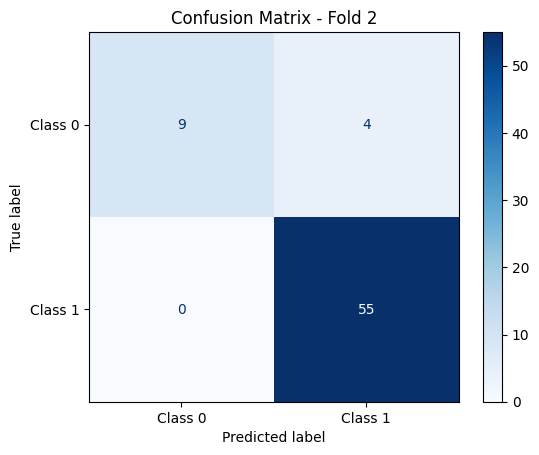

FOLD 3/5
Repressor IDs in Fold 3: ['ELK4-2', 'ESR2-2', 'MAZ-3', 'MEIS1-2', 'RFX4-3', 'ZBTB44-4', 'ZNF230-2', 'ZNF26-2', 'ZNF320-1', 'ZNF320-2', 'ZNF613-1']
Epoch [1/100], Train Loss: 0.4347, Val Loss: 0.4176, Train Acc: 0.2674, Val Acc: 0.3088
Repressor IDs in Fold 3: ['ELK4-2', 'ESR2-2', 'MAZ-3', 'MEIS1-2', 'RFX4-3', 'ZBTB44-4', 'ZNF230-2', 'ZNF26-2', 'ZNF320-1', 'ZNF320-2', 'ZNF613-1']
Epoch [2/100], Train Loss: 0.3896, Val Loss: 0.3812, Train Acc: 0.5641, Val Acc: 0.7794
Repressor IDs in Fold 3: ['ELK4-2', 'ESR2-2', 'MAZ-3', 'MEIS1-2', 'RFX4-3', 'ZBTB44-4', 'ZNF230-2', 'ZNF26-2', 'ZNF320-1', 'ZNF320-2', 'ZNF613-1']
Epoch [3/100], Train Loss: 0.3433, Val Loss: 0.3601, Train Acc: 0.8132, Val Acc: 0.8529
Repressor IDs in Fold 3: ['ELK4-2', 'ESR2-2', 'MAZ-3', 'MEIS1-2', 'RFX4-3', 'ZBTB44-4', 'ZNF230-2', 'ZNF26-2', 'ZNF320-1', 'ZNF320-2', 'ZNF613-1']
Epoch [4/100], Train Loss: 0.3208, Val Loss: 0.3479, Train Acc: 0.8645, Val Acc: 0.8529
Repressor IDs in Fold 3: ['ELK4-2', 'ESR2-2', 'MAZ-

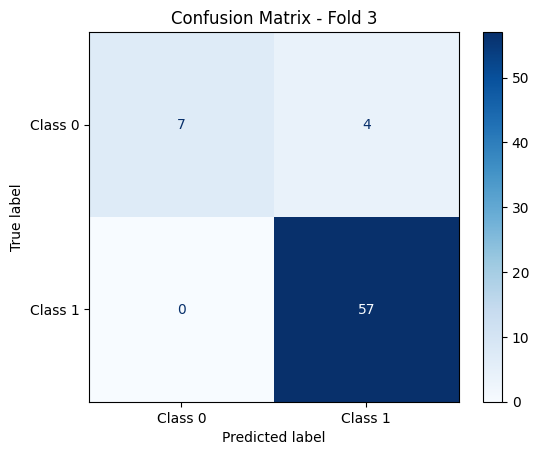

FOLD 4/5
Repressor IDs in Fold 4: ['ELK4-1', 'MEIS2-2', 'ZNF418-1', 'ZNF430-1', 'ZNF433-1', 'ZNF544-3']
Epoch [1/100], Train Loss: 0.3554, Val Loss: 0.2933, Train Acc: 0.7766, Val Acc: 0.9118
Repressor IDs in Fold 4: ['ELK4-1', 'MEIS2-2', 'ZNF418-1', 'ZNF430-1', 'ZNF433-1', 'ZNF544-3']
Epoch [2/100], Train Loss: 0.3317, Val Loss: 0.2739, Train Acc: 0.8352, Val Acc: 0.9118
Repressor IDs in Fold 4: ['ELK4-1', 'MEIS2-2', 'ZNF418-1', 'ZNF430-1', 'ZNF433-1', 'ZNF544-3']
Epoch [3/100], Train Loss: 0.3185, Val Loss: 0.2634, Train Acc: 0.8498, Val Acc: 0.9118
Repressor IDs in Fold 4: ['ELK4-1', 'MEIS2-2', 'ZNF418-1', 'ZNF430-1', 'ZNF433-1', 'ZNF544-3']
Epoch [4/100], Train Loss: 0.3069, Val Loss: 0.2530, Train Acc: 0.8462, Val Acc: 0.9118
Repressor IDs in Fold 4: ['ELK4-1', 'MEIS2-2', 'ZNF418-1', 'ZNF430-1', 'ZNF433-1', 'ZNF544-3']
Epoch [5/100], Train Loss: 0.2925, Val Loss: 0.2492, Train Acc: 0.8535, Val Acc: 0.9118
Repressor IDs in Fold 4: ['ELK4-1', 'MEIS2-2', 'ZNF418-1', 'ZNF430-1', 'ZNF4

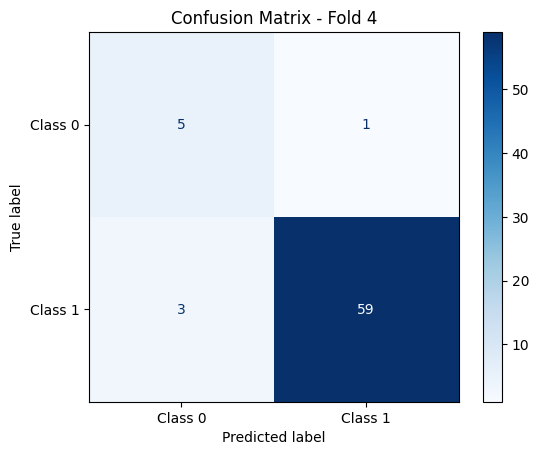

FOLD 5/5
Repressor IDs in Fold 5: ['MAX-3', 'MEIS3-2', 'PPARD-2', 'PPARD-3', 'ZBTB44-6', 'ZFP1-1', 'ZNF175-1', 'ZNF430-4', 'ZNF548-2']
Epoch [1/100], Train Loss: 0.3996, Val Loss: 0.3555, Train Acc: 0.5421, Val Acc: 0.7794
Repressor IDs in Fold 5: ['MAX-3', 'MEIS3-2', 'PPARD-2', 'PPARD-3', 'ZBTB44-6', 'ZFP1-1', 'ZNF175-1', 'ZNF430-4', 'ZNF548-2']
Epoch [2/100], Train Loss: 0.3438, Val Loss: 0.3240, Train Acc: 0.8059, Val Acc: 0.8824
Repressor IDs in Fold 5: ['MAX-3', 'MEIS3-2', 'PPARD-2', 'PPARD-3', 'ZBTB44-6', 'ZFP1-1', 'ZNF175-1', 'ZNF430-4', 'ZNF548-2']
Epoch [3/100], Train Loss: 0.3233, Val Loss: 0.3092, Train Acc: 0.8425, Val Acc: 0.8676
Repressor IDs in Fold 5: ['MAX-3', 'MEIS3-2', 'PPARD-2', 'PPARD-3', 'ZBTB44-6', 'ZFP1-1', 'ZNF175-1', 'ZNF430-4', 'ZNF548-2']
Epoch [4/100], Train Loss: 0.3152, Val Loss: 0.2990, Train Acc: 0.8535, Val Acc: 0.8676
Repressor IDs in Fold 5: ['MAX-3', 'MEIS3-2', 'PPARD-2', 'PPARD-3', 'ZBTB44-6', 'ZFP1-1', 'ZNF175-1', 'ZNF430-4', 'ZNF548-2']
Epoch [5/

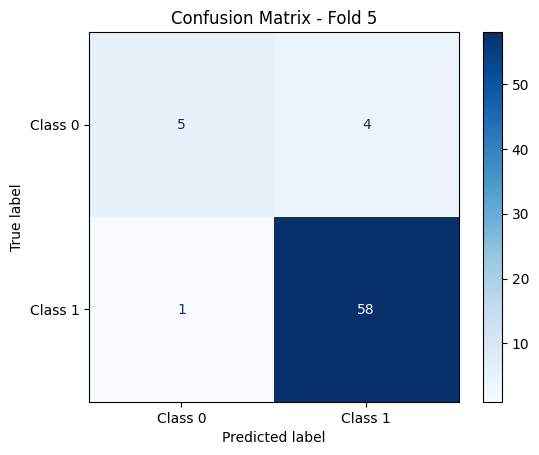


Average Validation Accuracy: 0.9471
Best Validation Accuracy: 0.9855


ValueError: too many values to unpack (expected 5)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
first_sequence, _, _ = dataset_iso[0]
input_dim = first_sequence.shape[-1]  # This gives the number of features per token

# Model parameters
# Training loop remains similar, adjust the model instantiation
best_model_state, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(
    dataset=dataset_iso,
    device=device,
    model_class=MLPBinaryClassifier,
    num_epochs=100,
    batch_size=16,
    learning_rate=.0001,
    pos_weight=0.5,
    neg_weight=1.0,
    k_folds=5,
    hidden_dim=64,
    augment_minority_class=False,
    weight_decay=.001
)


Experiments for finetuning

In [11]:
import itertools

hyperparameter_grid = {
    'num_epochs': [200],
    'batch_size': [16],
    'learning_rate': [.0001],
    'hidden_dim': [64],
    'pos_weight': [0.5, 0.6, 0.7, 1.0],
    'weight_decay': [.001],
    'neg_weight': [1.1, 1.2, 3],
    'augment_minority_class': [False]
}
# Generate all combinations of hyperparameters
keys = hyperparameter_grid.keys()
values = hyperparameter_grid.values()
combinations = list(itertools.product(*values))

# Create a list of dictionaries for each combination
hyperparameter_combinations = [dict(zip(keys, combo)) for combo in combinations]

print(f"Total hyperparameter combinations to evaluate: {len(hyperparameter_combinations)}")


Total hyperparameter combinations to evaluate: 12



Hyperparameter Combination 1/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.5, 'weight_decay': 0.001, 'neg_weight': 1.1, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.3419, Val Loss: 0.3005, Train Acc: 0.7978, Val Acc: 0.8696
Epoch [2/200], Train Loss: 0.3266, Val Loss: 0.2808, Train Acc: 0.8419, Val Acc: 0.8986
Epoch [3/200], Train Loss: 0.3188, Val Loss: 0.2670, Train Acc: 0.8493, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.3035, Val Loss: 0.2588, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.2902, Val Loss: 0.2503, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.2913, Val Loss: 0.2431, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.2640, Val Loss: 0.2359, Train Acc: 0.8787, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.2653, Val Loss: 0.2289, Train Acc: 0.8676, Val Acc: 0.8986
Epoch [9/200], Train Loss: 0.2607, Val Loss: 0.2195, Train Acc: 0.8934, Val Ac

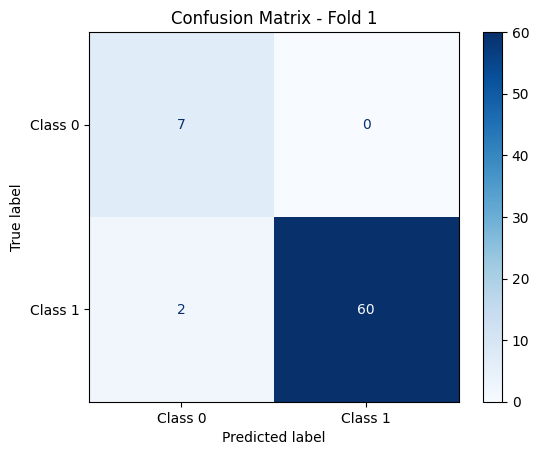

FOLD 2/5
Epoch [1/200], Train Loss: 0.4161, Val Loss: 0.4084, Train Acc: 0.3590, Val Acc: 0.5735
Epoch [2/200], Train Loss: 0.3702, Val Loss: 0.3856, Train Acc: 0.7106, Val Acc: 0.8235
Epoch [3/200], Train Loss: 0.3382, Val Loss: 0.3738, Train Acc: 0.8462, Val Acc: 0.8235
Epoch [4/200], Train Loss: 0.3186, Val Loss: 0.3649, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.3088, Val Loss: 0.3582, Train Acc: 0.8755, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.2939, Val Loss: 0.3545, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.2844, Val Loss: 0.3490, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.2727, Val Loss: 0.3365, Train Acc: 0.8901, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.2726, Val Loss: 0.3311, Train Acc: 0.8864, Val Acc: 0.8235
Epoch [10/200], Train Loss: 0.2558, Val Loss: 0.3242, Train Acc: 0.9048, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.2516, Val Loss: 0.3242, Train Acc: 0.9048, Val Acc: 0.8235
Epoch [12/200], Train

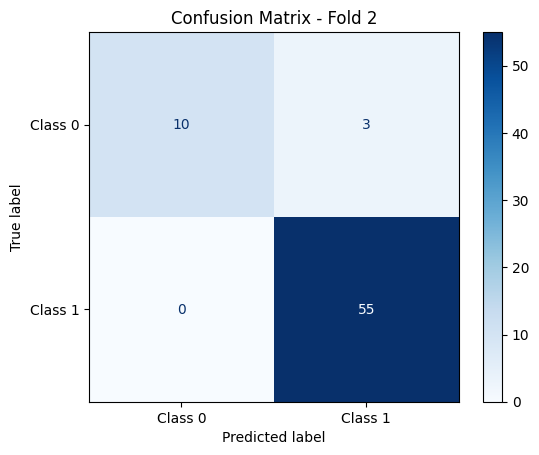

FOLD 3/5
Epoch [1/200], Train Loss: 0.4636, Val Loss: 0.4153, Train Acc: 0.1978, Val Acc: 0.4265
Epoch [2/200], Train Loss: 0.3999, Val Loss: 0.3818, Train Acc: 0.4579, Val Acc: 0.6912
Epoch [3/200], Train Loss: 0.3605, Val Loss: 0.3645, Train Acc: 0.7289, Val Acc: 0.7794
Epoch [4/200], Train Loss: 0.3422, Val Loss: 0.3536, Train Acc: 0.7985, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.3286, Val Loss: 0.3442, Train Acc: 0.8315, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.3179, Val Loss: 0.3380, Train Acc: 0.8645, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.2984, Val Loss: 0.3338, Train Acc: 0.8828, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.2931, Val Loss: 0.3288, Train Acc: 0.8864, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.2791, Val Loss: 0.3241, Train Acc: 0.9048, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2738, Val Loss: 0.3202, Train Acc: 0.9011, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.2701, Val Loss: 0.3174, Train Acc: 0.8864, Val Acc: 0.8382
Epoch [12/200], Train

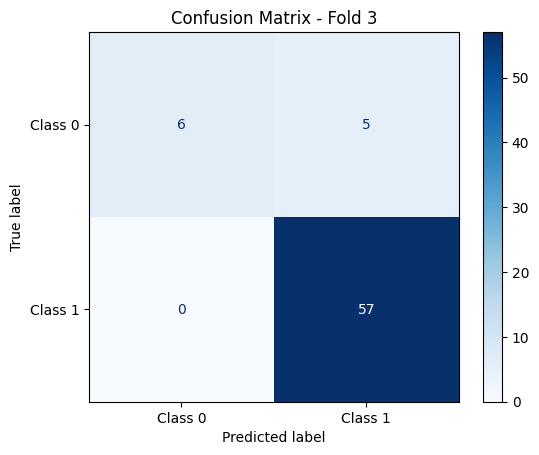

FOLD 4/5
Epoch [1/200], Train Loss: 0.3547, Val Loss: 0.2823, Train Acc: 0.7656, Val Acc: 0.9118
Epoch [2/200], Train Loss: 0.3223, Val Loss: 0.2610, Train Acc: 0.8498, Val Acc: 0.9118
Epoch [3/200], Train Loss: 0.3045, Val Loss: 0.2488, Train Acc: 0.8352, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.2921, Val Loss: 0.2388, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.2832, Val Loss: 0.2305, Train Acc: 0.8718, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.2768, Val Loss: 0.2257, Train Acc: 0.8645, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.2664, Val Loss: 0.2178, Train Acc: 0.8864, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.2559, Val Loss: 0.2129, Train Acc: 0.8755, Val Acc: 0.9265
Epoch [9/200], Train Loss: 0.2492, Val Loss: 0.2087, Train Acc: 0.8938, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.2363, Val Loss: 0.2025, Train Acc: 0.8901, Val Acc: 0.9412
Epoch [11/200], Train Loss: 0.2291, Val Loss: 0.1962, Train Acc: 0.9121, Val Acc: 0.9118
Epoch [12/200], Train

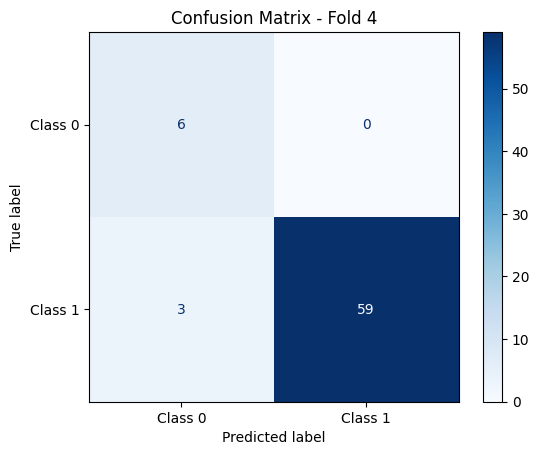

FOLD 5/5
Epoch [1/200], Train Loss: 0.3598, Val Loss: 0.3503, Train Acc: 0.7399, Val Acc: 0.8235
Epoch [2/200], Train Loss: 0.3259, Val Loss: 0.3273, Train Acc: 0.8498, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.3043, Val Loss: 0.3135, Train Acc: 0.8608, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.2976, Val Loss: 0.3047, Train Acc: 0.8791, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.2810, Val Loss: 0.2959, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.2708, Val Loss: 0.2891, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.2604, Val Loss: 0.2850, Train Acc: 0.8791, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.2538, Val Loss: 0.2797, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.2356, Val Loss: 0.2747, Train Acc: 0.8828, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.2357, Val Loss: 0.2707, Train Acc: 0.8864, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.2135, Val Loss: 0.2662, Train Acc: 0.9084, Val Acc: 0.8824
Epoch [12/200], Train

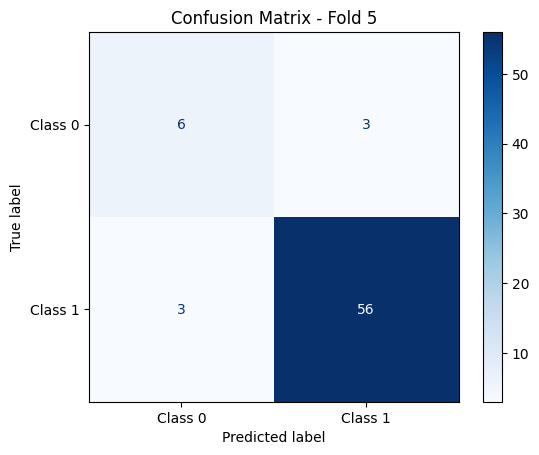


Average Validation Accuracy: 0.9442
Best Validation Accuracy: 0.9710
Completed Combination 1: Avg Val Accuracy = 0.9442

Hyperparameter Combination 2/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.5, 'weight_decay': 0.001, 'neg_weight': 1.2, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.4101, Val Loss: 0.3471, Train Acc: 0.4485, Val Acc: 0.7246
Epoch [2/200], Train Loss: 0.3639, Val Loss: 0.3055, Train Acc: 0.7353, Val Acc: 0.8116
Epoch [3/200], Train Loss: 0.3333, Val Loss: 0.2794, Train Acc: 0.8309, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.3191, Val Loss: 0.2670, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.3049, Val Loss: 0.2528, Train Acc: 0.8640, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.2964, Val Loss: 0.2429, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.2810, Val Loss: 0.2350, Train Acc: 0.8676, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.2747, Val Loss: 

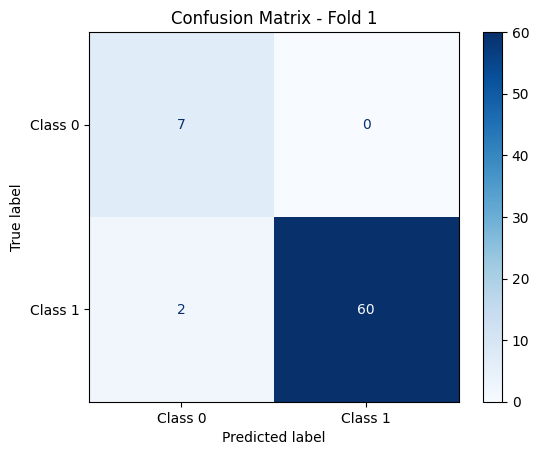

FOLD 2/5
Epoch [1/200], Train Loss: 0.3851, Val Loss: 0.3693, Train Acc: 0.5348, Val Acc: 0.6765
Epoch [2/200], Train Loss: 0.3320, Val Loss: 0.3532, Train Acc: 0.8059, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.2996, Val Loss: 0.3459, Train Acc: 0.8901, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.2796, Val Loss: 0.3390, Train Acc: 0.9011, Val Acc: 0.8235
Epoch [5/200], Train Loss: 0.2720, Val Loss: 0.3322, Train Acc: 0.9011, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.2535, Val Loss: 0.3279, Train Acc: 0.9194, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.2423, Val Loss: 0.3181, Train Acc: 0.9121, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.2406, Val Loss: 0.3101, Train Acc: 0.9048, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.2306, Val Loss: 0.2967, Train Acc: 0.9194, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2173, Val Loss: 0.2800, Train Acc: 0.9304, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.2100, Val Loss: 0.2761, Train Acc: 0.9267, Val Acc: 0.8529
Epoch [12/200], Train

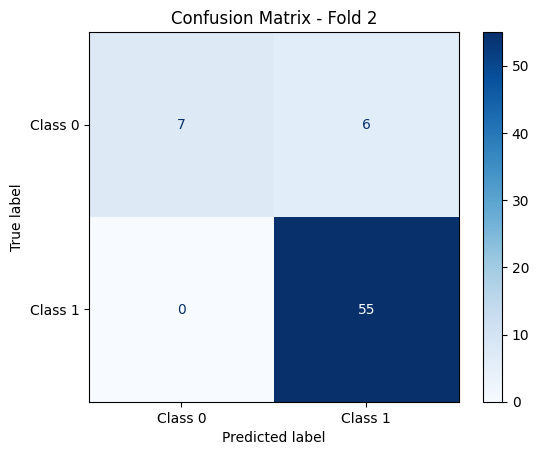

FOLD 3/5
Epoch [1/200], Train Loss: 0.3988, Val Loss: 0.3679, Train Acc: 0.4908, Val Acc: 0.8088
Epoch [2/200], Train Loss: 0.3550, Val Loss: 0.3445, Train Acc: 0.7509, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.3257, Val Loss: 0.3324, Train Acc: 0.8645, Val Acc: 0.8235
Epoch [4/200], Train Loss: 0.3113, Val Loss: 0.3237, Train Acc: 0.8718, Val Acc: 0.8235
Epoch [5/200], Train Loss: 0.2979, Val Loss: 0.3162, Train Acc: 0.8791, Val Acc: 0.8235
Epoch [6/200], Train Loss: 0.2959, Val Loss: 0.3100, Train Acc: 0.8681, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.2769, Val Loss: 0.3033, Train Acc: 0.8938, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.2730, Val Loss: 0.2971, Train Acc: 0.9011, Val Acc: 0.8529
Epoch [9/200], Train Loss: 0.2617, Val Loss: 0.2898, Train Acc: 0.8938, Val Acc: 0.8824
Epoch [10/200], Train Loss: 0.2511, Val Loss: 0.2837, Train Acc: 0.9084, Val Acc: 0.8971
Epoch [11/200], Train Loss: 0.2582, Val Loss: 0.2752, Train Acc: 0.8864, Val Acc: 0.8971
Epoch [12/200], Train

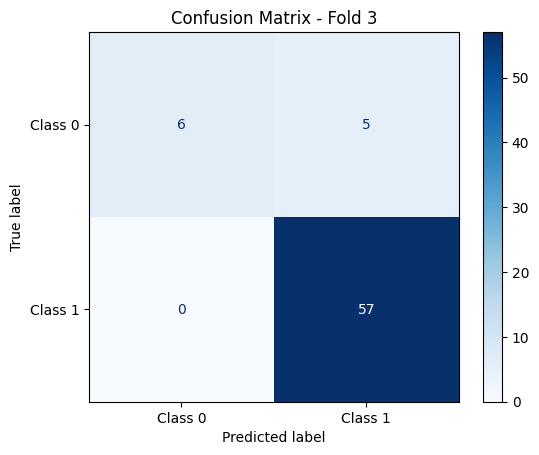

FOLD 4/5
Epoch [1/200], Train Loss: 0.4357, Val Loss: 0.3820, Train Acc: 0.3077, Val Acc: 0.4265
Epoch [2/200], Train Loss: 0.3848, Val Loss: 0.3428, Train Acc: 0.5897, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.3553, Val Loss: 0.3148, Train Acc: 0.7289, Val Acc: 0.8971
Epoch [4/200], Train Loss: 0.3464, Val Loss: 0.2961, Train Acc: 0.8095, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.3317, Val Loss: 0.2891, Train Acc: 0.8425, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.3190, Val Loss: 0.2786, Train Acc: 0.8535, Val Acc: 0.9265
Epoch [7/200], Train Loss: 0.3124, Val Loss: 0.2705, Train Acc: 0.8498, Val Acc: 0.9265
Epoch [8/200], Train Loss: 0.3026, Val Loss: 0.2621, Train Acc: 0.8462, Val Acc: 0.9265
Epoch [9/200], Train Loss: 0.2951, Val Loss: 0.2558, Train Acc: 0.8571, Val Acc: 0.9265
Epoch [10/200], Train Loss: 0.2832, Val Loss: 0.2494, Train Acc: 0.8828, Val Acc: 0.9265
Epoch [11/200], Train Loss: 0.2758, Val Loss: 0.2417, Train Acc: 0.8864, Val Acc: 0.9265
Epoch [12/200], Train

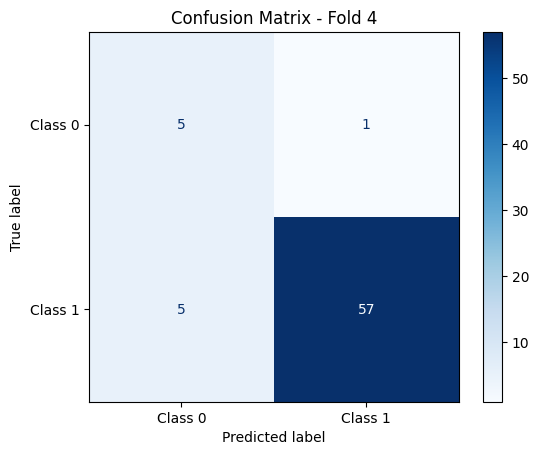

FOLD 5/5
Epoch [1/200], Train Loss: 0.4336, Val Loss: 0.3980, Train Acc: 0.2967, Val Acc: 0.4559
Epoch [2/200], Train Loss: 0.3775, Val Loss: 0.3568, Train Acc: 0.6227, Val Acc: 0.7941
Epoch [3/200], Train Loss: 0.3353, Val Loss: 0.3319, Train Acc: 0.8498, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.3236, Val Loss: 0.3159, Train Acc: 0.8571, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.2932, Val Loss: 0.3055, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.2933, Val Loss: 0.2965, Train Acc: 0.8791, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.2768, Val Loss: 0.2897, Train Acc: 0.8828, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.2701, Val Loss: 0.2835, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.2584, Val Loss: 0.2778, Train Acc: 0.8864, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.2434, Val Loss: 0.2736, Train Acc: 0.9011, Val Acc: 0.8529
Epoch [11/200], Train Loss: 0.2336, Val Loss: 0.2678, Train Acc: 0.8938, Val Acc: 0.8529
Epoch [12/200], Train

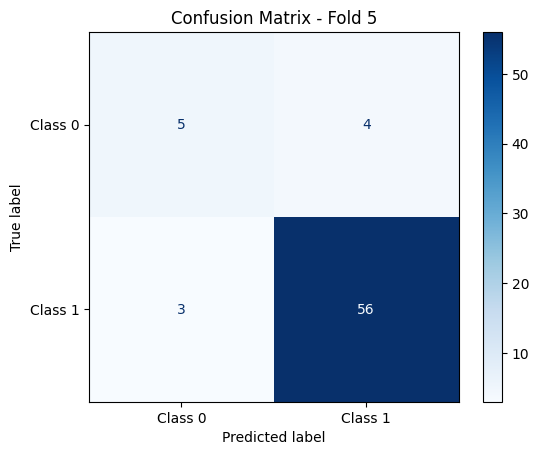


Average Validation Accuracy: 0.9236
Best Validation Accuracy: 0.9710
Completed Combination 2: Avg Val Accuracy = 0.9236

Hyperparameter Combination 3/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.5, 'weight_decay': 0.001, 'neg_weight': 3, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.3873, Val Loss: 0.3573, Train Acc: 0.5735, Val Acc: 0.7536
Epoch [2/200], Train Loss: 0.3542, Val Loss: 0.3255, Train Acc: 0.8015, Val Acc: 0.8841
Epoch [3/200], Train Loss: 0.3274, Val Loss: 0.3027, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.3211, Val Loss: 0.2867, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.3097, Val Loss: 0.2751, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.2993, Val Loss: 0.2647, Train Acc: 0.8676, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.2860, Val Loss: 0.2564, Train Acc: 0.8750, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.2791, Val Loss: 0.

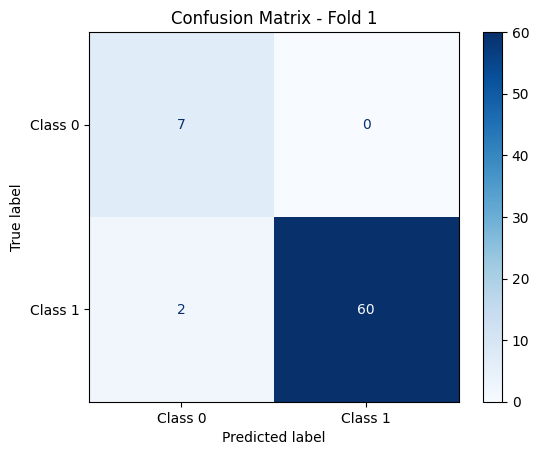

FOLD 2/5
Epoch [1/200], Train Loss: 0.3593, Val Loss: 0.3749, Train Acc: 0.6557, Val Acc: 0.7647
Epoch [2/200], Train Loss: 0.3278, Val Loss: 0.3614, Train Acc: 0.8132, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.2960, Val Loss: 0.3579, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.2864, Val Loss: 0.3551, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.2687, Val Loss: 0.3541, Train Acc: 0.8864, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.2649, Val Loss: 0.3520, Train Acc: 0.8901, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.2494, Val Loss: 0.3500, Train Acc: 0.9011, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.2379, Val Loss: 0.3451, Train Acc: 0.9121, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.2362, Val Loss: 0.3437, Train Acc: 0.9011, Val Acc: 0.8088
Epoch [10/200], Train Loss: 0.2189, Val Loss: 0.3368, Train Acc: 0.9194, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.2218, Val Loss: 0.3326, Train Acc: 0.9194, Val Acc: 0.8382
Epoch [12/200], Train

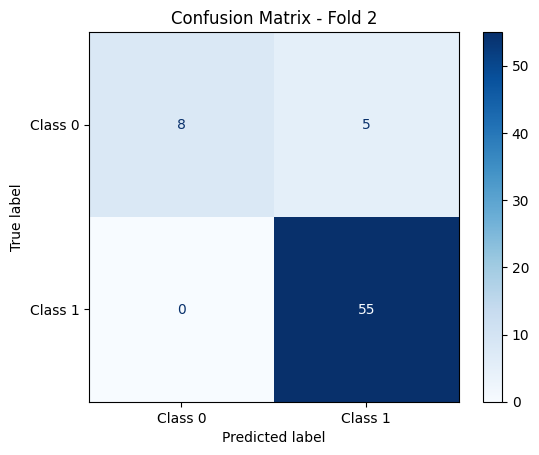

FOLD 3/5
Epoch [1/200], Train Loss: 0.3738, Val Loss: 0.3765, Train Acc: 0.7326, Val Acc: 0.8088
Epoch [2/200], Train Loss: 0.3321, Val Loss: 0.3592, Train Acc: 0.8388, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.3175, Val Loss: 0.3476, Train Acc: 0.8608, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.3000, Val Loss: 0.3404, Train Acc: 0.8681, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.2888, Val Loss: 0.3352, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.2808, Val Loss: 0.3303, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.2764, Val Loss: 0.3253, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.2680, Val Loss: 0.3202, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.2611, Val Loss: 0.3154, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2584, Val Loss: 0.3086, Train Acc: 0.8938, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.2526, Val Loss: 0.3014, Train Acc: 0.8901, Val Acc: 0.8382
Epoch [12/200], Train

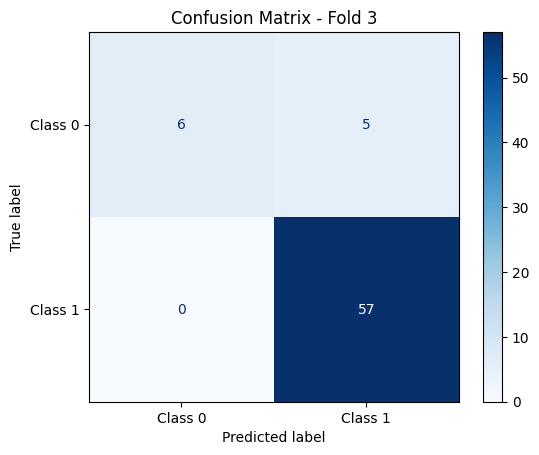

FOLD 4/5
Epoch [1/200], Train Loss: 0.3728, Val Loss: 0.3148, Train Acc: 0.7179, Val Acc: 0.8824
Epoch [2/200], Train Loss: 0.3494, Val Loss: 0.2907, Train Acc: 0.8132, Val Acc: 0.9118
Epoch [3/200], Train Loss: 0.3212, Val Loss: 0.2759, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.3137, Val Loss: 0.2660, Train Acc: 0.8498, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.2890, Val Loss: 0.2593, Train Acc: 0.8608, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.2836, Val Loss: 0.2502, Train Acc: 0.8645, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.2725, Val Loss: 0.2446, Train Acc: 0.8791, Val Acc: 0.9265
Epoch [8/200], Train Loss: 0.2564, Val Loss: 0.2372, Train Acc: 0.8974, Val Acc: 0.9265
Epoch [9/200], Train Loss: 0.2472, Val Loss: 0.2352, Train Acc: 0.9158, Val Acc: 0.8824
Epoch [10/200], Train Loss: 0.2345, Val Loss: 0.2272, Train Acc: 0.9158, Val Acc: 0.8824
Epoch [11/200], Train Loss: 0.2339, Val Loss: 0.2251, Train Acc: 0.9121, Val Acc: 0.8824
Epoch [12/200], Train

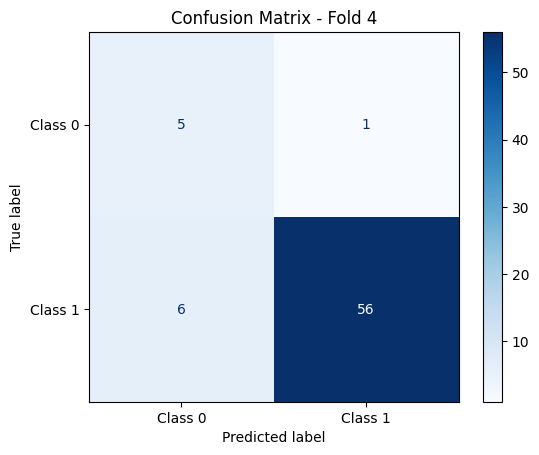

FOLD 5/5
Epoch [1/200], Train Loss: 0.4254, Val Loss: 0.3824, Train Acc: 0.3736, Val Acc: 0.5882
Epoch [2/200], Train Loss: 0.3743, Val Loss: 0.3424, Train Acc: 0.6630, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.3343, Val Loss: 0.3201, Train Acc: 0.8498, Val Acc: 0.8824
Epoch [4/200], Train Loss: 0.3205, Val Loss: 0.3081, Train Acc: 0.8645, Val Acc: 0.8824
Epoch [5/200], Train Loss: 0.3183, Val Loss: 0.2992, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.3069, Val Loss: 0.2928, Train Acc: 0.8681, Val Acc: 0.8824
Epoch [7/200], Train Loss: 0.2921, Val Loss: 0.2885, Train Acc: 0.8755, Val Acc: 0.8824
Epoch [8/200], Train Loss: 0.2880, Val Loss: 0.2835, Train Acc: 0.8755, Val Acc: 0.8824
Epoch [9/200], Train Loss: 0.2806, Val Loss: 0.2778, Train Acc: 0.8791, Val Acc: 0.8824
Epoch [10/200], Train Loss: 0.2693, Val Loss: 0.2726, Train Acc: 0.8864, Val Acc: 0.8824
Epoch [11/200], Train Loss: 0.2632, Val Loss: 0.2683, Train Acc: 0.8938, Val Acc: 0.8824
Epoch [12/200], Train

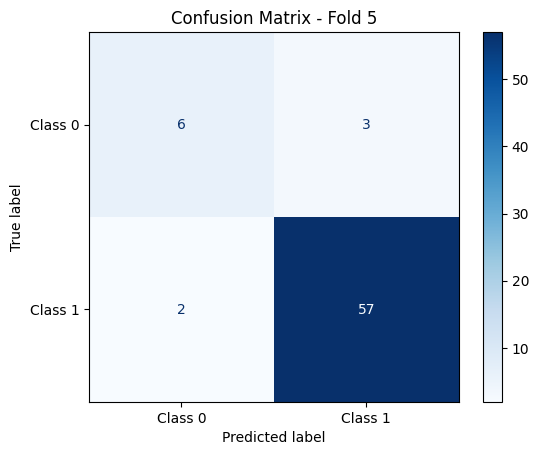


Average Validation Accuracy: 0.9295
Best Validation Accuracy: 0.9710
Completed Combination 3: Avg Val Accuracy = 0.9295

Hyperparameter Combination 4/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.6, 'weight_decay': 0.001, 'neg_weight': 1.1, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.4379, Val Loss: 0.3622, Train Acc: 0.6250, Val Acc: 0.8841
Epoch [2/200], Train Loss: 0.3904, Val Loss: 0.3138, Train Acc: 0.8456, Val Acc: 0.9420
Epoch [3/200], Train Loss: 0.3613, Val Loss: 0.2905, Train Acc: 0.8750, Val Acc: 0.9130
Epoch [4/200], Train Loss: 0.3435, Val Loss: 0.2749, Train Acc: 0.8640, Val Acc: 0.9130
Epoch [5/200], Train Loss: 0.3219, Val Loss: 0.2651, Train Acc: 0.8676, Val Acc: 0.9130
Epoch [6/200], Train Loss: 0.3203, Val Loss: 0.2539, Train Acc: 0.8676, Val Acc: 0.9130
Epoch [7/200], Train Loss: 0.3076, Val Loss: 0.2446, Train Acc: 0.8787, Val Acc: 0.9130
Epoch [8/200], Train Loss: 0.2983, Val Loss: 

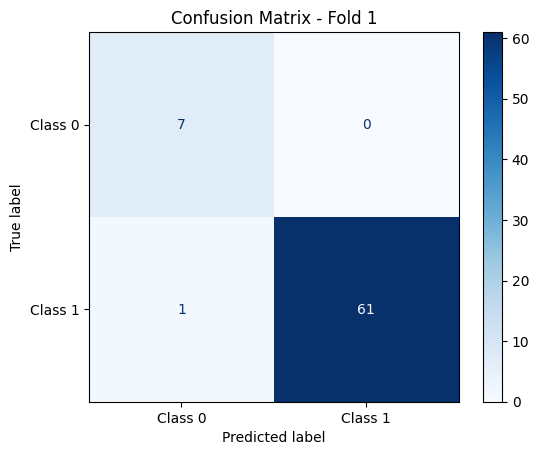

FOLD 2/5
Epoch [1/200], Train Loss: 0.3571, Val Loss: 0.4049, Train Acc: 0.8718, Val Acc: 0.8088
Epoch [2/200], Train Loss: 0.3363, Val Loss: 0.3963, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.3184, Val Loss: 0.3954, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.2997, Val Loss: 0.3926, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.2903, Val Loss: 0.3895, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.2789, Val Loss: 0.3823, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.2757, Val Loss: 0.3778, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.2612, Val Loss: 0.3701, Train Acc: 0.8864, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.2570, Val Loss: 0.3645, Train Acc: 0.8901, Val Acc: 0.8088
Epoch [10/200], Train Loss: 0.2477, Val Loss: 0.3574, Train Acc: 0.9084, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.2363, Val Loss: 0.3451, Train Acc: 0.9048, Val Acc: 0.8235
Epoch [12/200], Train

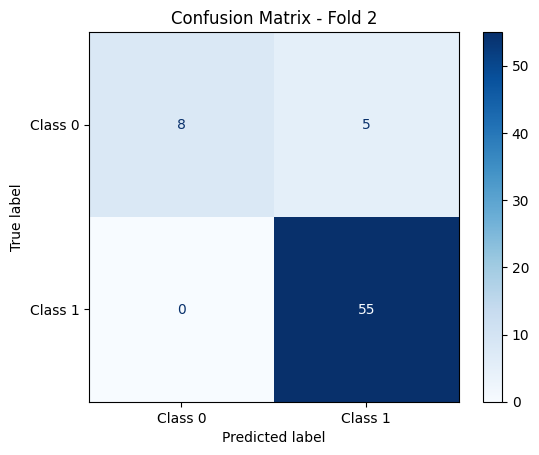

FOLD 3/5
Epoch [1/200], Train Loss: 0.4903, Val Loss: 0.4433, Train Acc: 0.3700, Val Acc: 0.6618
Epoch [2/200], Train Loss: 0.4147, Val Loss: 0.3949, Train Acc: 0.6996, Val Acc: 0.8235
Epoch [3/200], Train Loss: 0.3725, Val Loss: 0.3708, Train Acc: 0.8278, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.3438, Val Loss: 0.3578, Train Acc: 0.8645, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.3292, Val Loss: 0.3484, Train Acc: 0.8681, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.3106, Val Loss: 0.3403, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.3084, Val Loss: 0.3305, Train Acc: 0.8681, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.2916, Val Loss: 0.3227, Train Acc: 0.8938, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.2743, Val Loss: 0.3139, Train Acc: 0.8974, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2664, Val Loss: 0.3009, Train Acc: 0.8974, Val Acc: 0.8529
Epoch [11/200], Train Loss: 0.2487, Val Loss: 0.2941, Train Acc: 0.9158, Val Acc: 0.8824
Epoch [12/200], Train

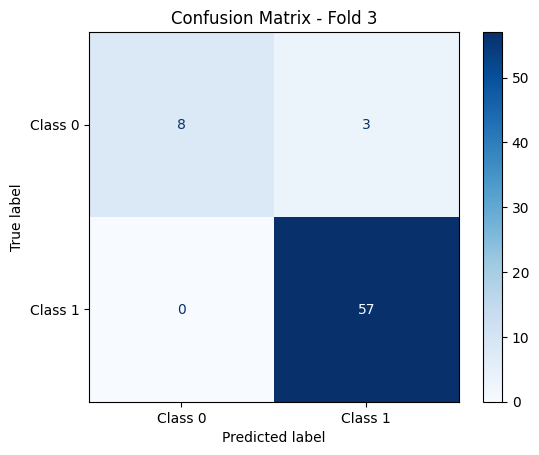

FOLD 4/5
Epoch [1/200], Train Loss: 0.4309, Val Loss: 0.3719, Train Acc: 0.6264, Val Acc: 0.8676
Epoch [2/200], Train Loss: 0.3816, Val Loss: 0.3246, Train Acc: 0.8132, Val Acc: 0.9118
Epoch [3/200], Train Loss: 0.3545, Val Loss: 0.2958, Train Acc: 0.8425, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.3374, Val Loss: 0.2821, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.3173, Val Loss: 0.2684, Train Acc: 0.8645, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.2980, Val Loss: 0.2552, Train Acc: 0.8901, Val Acc: 0.9265
Epoch [7/200], Train Loss: 0.2836, Val Loss: 0.2459, Train Acc: 0.8901, Val Acc: 0.9265
Epoch [8/200], Train Loss: 0.2770, Val Loss: 0.2359, Train Acc: 0.9011, Val Acc: 0.9265
Epoch [9/200], Train Loss: 0.2700, Val Loss: 0.2310, Train Acc: 0.9084, Val Acc: 0.9265
Epoch [10/200], Train Loss: 0.2552, Val Loss: 0.2241, Train Acc: 0.9121, Val Acc: 0.9265
Epoch [11/200], Train Loss: 0.2469, Val Loss: 0.2183, Train Acc: 0.9194, Val Acc: 0.9265
Epoch [12/200], Train

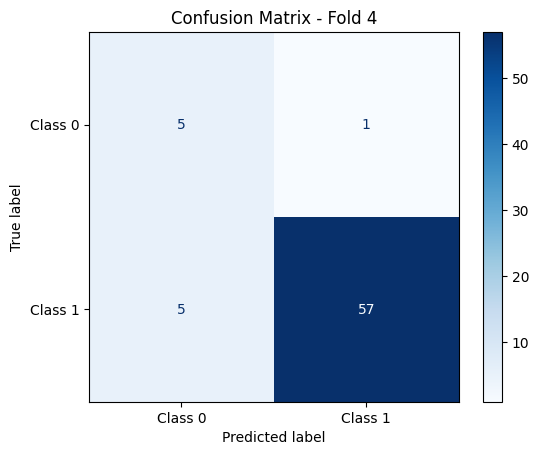

FOLD 5/5
Epoch [1/200], Train Loss: 0.5063, Val Loss: 0.4312, Train Acc: 0.3150, Val Acc: 0.6471
Epoch [2/200], Train Loss: 0.4227, Val Loss: 0.3822, Train Acc: 0.6850, Val Acc: 0.8824
Epoch [3/200], Train Loss: 0.3831, Val Loss: 0.3527, Train Acc: 0.8242, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.3660, Val Loss: 0.3353, Train Acc: 0.8535, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.3436, Val Loss: 0.3238, Train Acc: 0.8535, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.3255, Val Loss: 0.3143, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.3213, Val Loss: 0.3062, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3068, Val Loss: 0.2989, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.2963, Val Loss: 0.2926, Train Acc: 0.8791, Val Acc: 0.8824
Epoch [10/200], Train Loss: 0.2916, Val Loss: 0.2875, Train Acc: 0.8718, Val Acc: 0.8824
Epoch [11/200], Train Loss: 0.2738, Val Loss: 0.2816, Train Acc: 0.8901, Val Acc: 0.8824
Epoch [12/200], Train

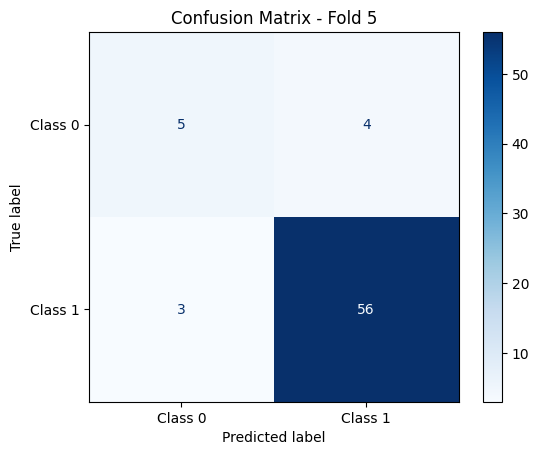


Average Validation Accuracy: 0.9353
Best Validation Accuracy: 0.9855
Completed Combination 4: Avg Val Accuracy = 0.9353

Hyperparameter Combination 5/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.6, 'weight_decay': 0.001, 'neg_weight': 1.2, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.4442, Val Loss: 0.3829, Train Acc: 0.5772, Val Acc: 0.8116
Epoch [2/200], Train Loss: 0.3891, Val Loss: 0.3351, Train Acc: 0.7941, Val Acc: 0.8696
Epoch [3/200], Train Loss: 0.3605, Val Loss: 0.3115, Train Acc: 0.8603, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.3469, Val Loss: 0.2956, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.3369, Val Loss: 0.2859, Train Acc: 0.8713, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.3159, Val Loss: 0.2772, Train Acc: 0.8603, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.3167, Val Loss: 0.2693, Train Acc: 0.8750, Val Acc: 0.9130
Epoch [8/200], Train Loss: 0.3115, Val Loss: 

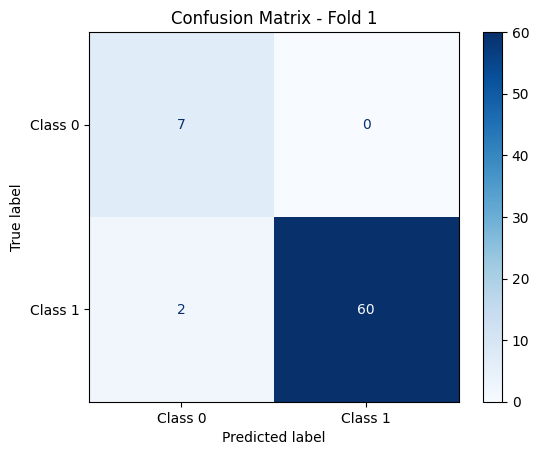

FOLD 2/5
Epoch [1/200], Train Loss: 0.3925, Val Loss: 0.4258, Train Acc: 0.8388, Val Acc: 0.8088
Epoch [2/200], Train Loss: 0.3516, Val Loss: 0.4137, Train Acc: 0.8681, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.3329, Val Loss: 0.4064, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.3202, Val Loss: 0.4005, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.3064, Val Loss: 0.3964, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.2973, Val Loss: 0.3908, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.2995, Val Loss: 0.3887, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.2837, Val Loss: 0.3817, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.2749, Val Loss: 0.3761, Train Acc: 0.8864, Val Acc: 0.8088
Epoch [10/200], Train Loss: 0.2715, Val Loss: 0.3724, Train Acc: 0.8864, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.2630, Val Loss: 0.3650, Train Acc: 0.8828, Val Acc: 0.8235
Epoch [12/200], Train

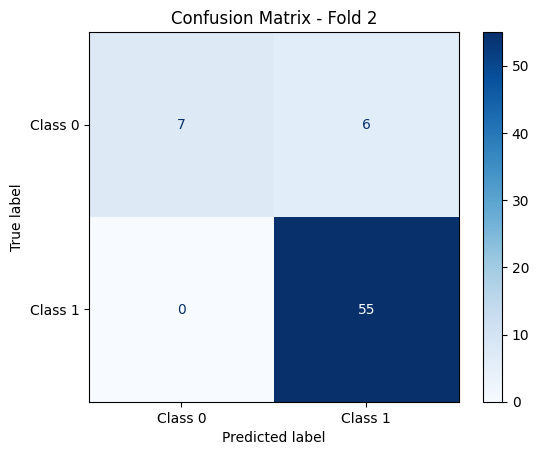

FOLD 3/5
Epoch [1/200], Train Loss: 0.3874, Val Loss: 0.3799, Train Acc: 0.7875, Val Acc: 0.8382
Epoch [2/200], Train Loss: 0.3503, Val Loss: 0.3638, Train Acc: 0.8571, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.3222, Val Loss: 0.3558, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.3107, Val Loss: 0.3509, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.3038, Val Loss: 0.3484, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.2893, Val Loss: 0.3443, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.2796, Val Loss: 0.3398, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.2797, Val Loss: 0.3335, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.2590, Val Loss: 0.3298, Train Acc: 0.8901, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2555, Val Loss: 0.3235, Train Acc: 0.8901, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.2495, Val Loss: 0.3201, Train Acc: 0.8938, Val Acc: 0.8382
Epoch [12/200], Train

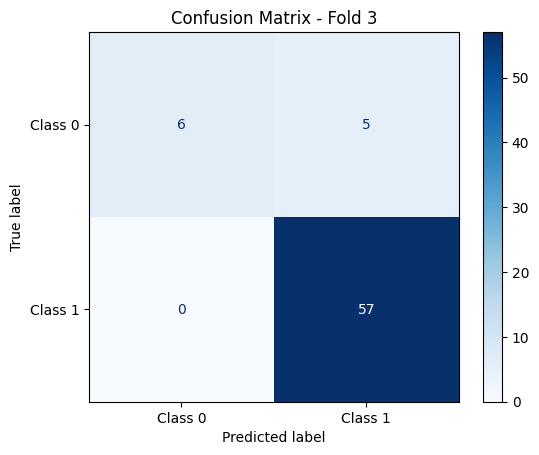

FOLD 4/5
Epoch [1/200], Train Loss: 0.4319, Val Loss: 0.3823, Train Acc: 0.6447, Val Acc: 0.8382
Epoch [2/200], Train Loss: 0.3839, Val Loss: 0.3326, Train Acc: 0.7985, Val Acc: 0.9118
Epoch [3/200], Train Loss: 0.3643, Val Loss: 0.3093, Train Acc: 0.8278, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.3478, Val Loss: 0.2955, Train Acc: 0.8498, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.3390, Val Loss: 0.2865, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.3231, Val Loss: 0.2833, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.3192, Val Loss: 0.2823, Train Acc: 0.8645, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.3086, Val Loss: 0.2749, Train Acc: 0.8864, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.3033, Val Loss: 0.2675, Train Acc: 0.8791, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.2831, Val Loss: 0.2601, Train Acc: 0.8828, Val Acc: 0.9118
Epoch [11/200], Train Loss: 0.2821, Val Loss: 0.2542, Train Acc: 0.8828, Val Acc: 0.9412
Epoch [12/200], Train

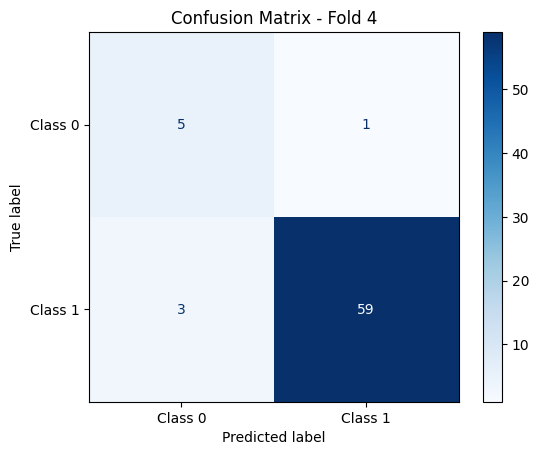

FOLD 5/5
Epoch [1/200], Train Loss: 0.4170, Val Loss: 0.3717, Train Acc: 0.7289, Val Acc: 0.8529
Epoch [2/200], Train Loss: 0.3703, Val Loss: 0.3458, Train Acc: 0.8498, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.3546, Val Loss: 0.3310, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.3434, Val Loss: 0.3244, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.3318, Val Loss: 0.3192, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.3193, Val Loss: 0.3129, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.3090, Val Loss: 0.3070, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.2943, Val Loss: 0.3005, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.2959, Val Loss: 0.2926, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.2899, Val Loss: 0.2863, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.2774, Val Loss: 0.2829, Train Acc: 0.8645, Val Acc: 0.8824
Epoch [12/200], Train

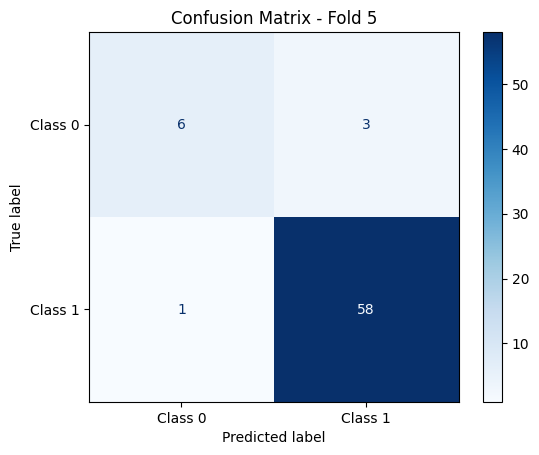


Average Validation Accuracy: 0.9383
Best Validation Accuracy: 0.9710
Completed Combination 5: Avg Val Accuracy = 0.9383

Hyperparameter Combination 6/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.6, 'weight_decay': 0.001, 'neg_weight': 3, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.3596, Val Loss: 0.2955, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [2/200], Train Loss: 0.3424, Val Loss: 0.2839, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [3/200], Train Loss: 0.3403, Val Loss: 0.2749, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.3254, Val Loss: 0.2650, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.3219, Val Loss: 0.2575, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.3104, Val Loss: 0.2502, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.3073, Val Loss: 0.2436, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.2998, Val Loss: 0.

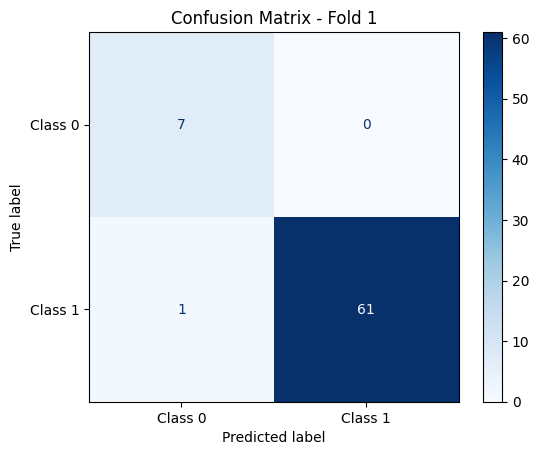

FOLD 2/5
Epoch [1/200], Train Loss: 0.3312, Val Loss: 0.3950, Train Acc: 0.8755, Val Acc: 0.8088
Epoch [2/200], Train Loss: 0.3139, Val Loss: 0.3958, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.2970, Val Loss: 0.3882, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.2842, Val Loss: 0.3823, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.2800, Val Loss: 0.3815, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.2762, Val Loss: 0.3763, Train Acc: 0.8864, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.2704, Val Loss: 0.3653, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.2522, Val Loss: 0.3613, Train Acc: 0.8864, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.2517, Val Loss: 0.3472, Train Acc: 0.8938, Val Acc: 0.8235
Epoch [10/200], Train Loss: 0.2359, Val Loss: 0.3353, Train Acc: 0.8974, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.2375, Val Loss: 0.3206, Train Acc: 0.9121, Val Acc: 0.8235
Epoch [12/200], Train

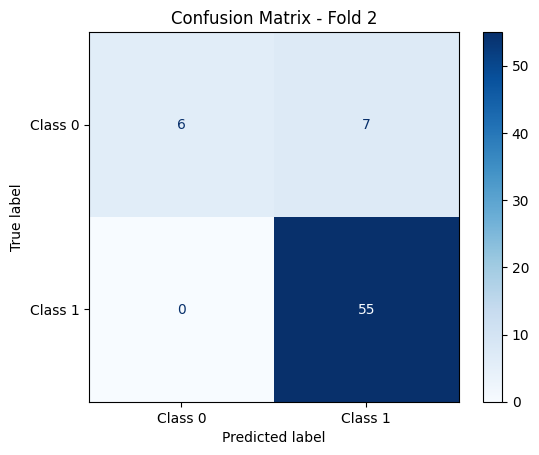

FOLD 3/5
Epoch [1/200], Train Loss: 0.4235, Val Loss: 0.3909, Train Acc: 0.6337, Val Acc: 0.7794
Epoch [2/200], Train Loss: 0.3711, Val Loss: 0.3651, Train Acc: 0.8132, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.3329, Val Loss: 0.3541, Train Acc: 0.8608, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.3180, Val Loss: 0.3455, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.3027, Val Loss: 0.3363, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.2900, Val Loss: 0.3283, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.2878, Val Loss: 0.3211, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.2792, Val Loss: 0.3158, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.2567, Val Loss: 0.3100, Train Acc: 0.8938, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2571, Val Loss: 0.3038, Train Acc: 0.8828, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.2526, Val Loss: 0.2972, Train Acc: 0.8901, Val Acc: 0.8529
Epoch [12/200], Train

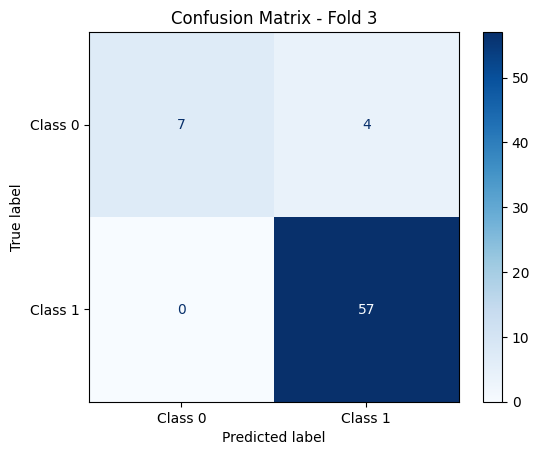

FOLD 4/5
Epoch [1/200], Train Loss: 0.5263, Val Loss: 0.4731, Train Acc: 0.2454, Val Acc: 0.3529
Epoch [2/200], Train Loss: 0.4551, Val Loss: 0.4002, Train Acc: 0.4945, Val Acc: 0.7794
Epoch [3/200], Train Loss: 0.4081, Val Loss: 0.3539, Train Acc: 0.7326, Val Acc: 0.8971
Epoch [4/200], Train Loss: 0.3715, Val Loss: 0.3241, Train Acc: 0.8498, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.3575, Val Loss: 0.3052, Train Acc: 0.8462, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.3427, Val Loss: 0.2916, Train Acc: 0.8608, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.3307, Val Loss: 0.2804, Train Acc: 0.8608, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.3114, Val Loss: 0.2701, Train Acc: 0.8755, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.3059, Val Loss: 0.2608, Train Acc: 0.8681, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.2972, Val Loss: 0.2551, Train Acc: 0.8791, Val Acc: 0.9118
Epoch [11/200], Train Loss: 0.2804, Val Loss: 0.2493, Train Acc: 0.8938, Val Acc: 0.9559
Epoch [12/200], Train

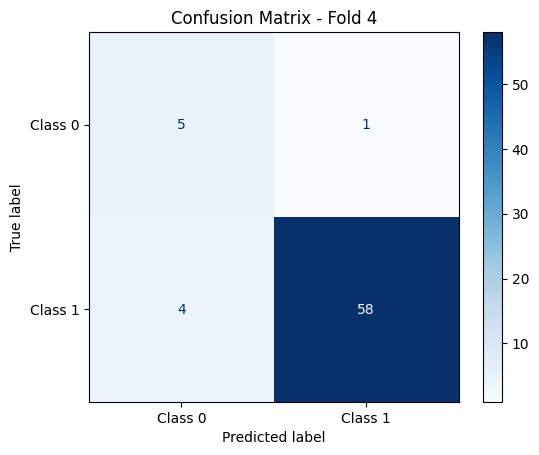

FOLD 5/5
Epoch [1/200], Train Loss: 0.4795, Val Loss: 0.4362, Train Acc: 0.3480, Val Acc: 0.6618
Epoch [2/200], Train Loss: 0.4328, Val Loss: 0.4037, Train Acc: 0.7033, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.4017, Val Loss: 0.3849, Train Acc: 0.8205, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.3835, Val Loss: 0.3708, Train Acc: 0.8608, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.3728, Val Loss: 0.3610, Train Acc: 0.8608, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.3619, Val Loss: 0.3548, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.3503, Val Loss: 0.3483, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3407, Val Loss: 0.3408, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.3342, Val Loss: 0.3343, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.3256, Val Loss: 0.3281, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.3159, Val Loss: 0.3207, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [12/200], Train

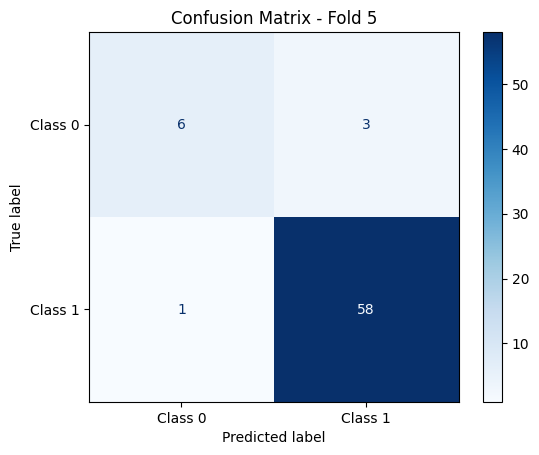


Average Validation Accuracy: 0.9383
Best Validation Accuracy: 0.9855
Completed Combination 6: Avg Val Accuracy = 0.9383

Hyperparameter Combination 7/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.7, 'weight_decay': 0.001, 'neg_weight': 1.1, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.4262, Val Loss: 0.3617, Train Acc: 0.8419, Val Acc: 0.8986
Epoch [2/200], Train Loss: 0.3937, Val Loss: 0.3331, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [3/200], Train Loss: 0.3749, Val Loss: 0.3161, Train Acc: 0.8603, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.3695, Val Loss: 0.3048, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.3575, Val Loss: 0.2953, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.3430, Val Loss: 0.2881, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.3321, Val Loss: 0.2796, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.3315, Val Loss: 

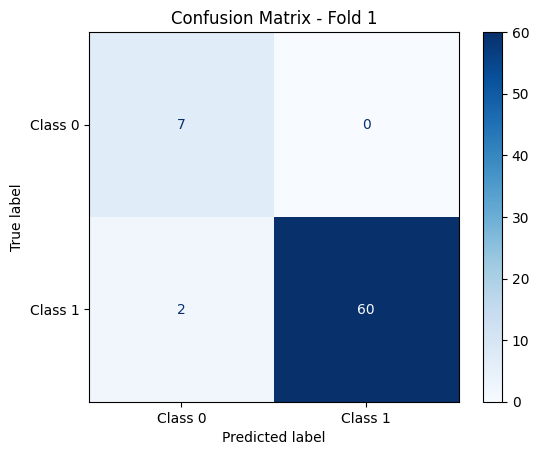

FOLD 2/5
Epoch [1/200], Train Loss: 0.4294, Val Loss: 0.4338, Train Acc: 0.7766, Val Acc: 0.8088
Epoch [2/200], Train Loss: 0.3689, Val Loss: 0.4174, Train Acc: 0.8755, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.3511, Val Loss: 0.4083, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.3265, Val Loss: 0.4070, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.3145, Val Loss: 0.4034, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.3124, Val Loss: 0.3990, Train Acc: 0.8755, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.2985, Val Loss: 0.3953, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.2926, Val Loss: 0.3928, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.2777, Val Loss: 0.3906, Train Acc: 0.8901, Val Acc: 0.8235
Epoch [10/200], Train Loss: 0.2655, Val Loss: 0.3846, Train Acc: 0.8974, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.2603, Val Loss: 0.3764, Train Acc: 0.9011, Val Acc: 0.8235
Epoch [12/200], Train

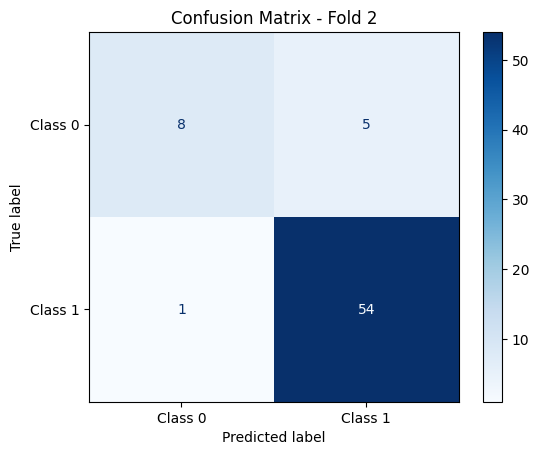

FOLD 3/5
Epoch [1/200], Train Loss: 0.5041, Val Loss: 0.4718, Train Acc: 0.5934, Val Acc: 0.7941
Epoch [2/200], Train Loss: 0.4412, Val Loss: 0.4338, Train Acc: 0.8205, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.4040, Val Loss: 0.4131, Train Acc: 0.8535, Val Acc: 0.8235
Epoch [4/200], Train Loss: 0.3722, Val Loss: 0.3994, Train Acc: 0.8755, Val Acc: 0.8235
Epoch [5/200], Train Loss: 0.3598, Val Loss: 0.3904, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.3543, Val Loss: 0.3833, Train Acc: 0.8681, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.3427, Val Loss: 0.3774, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.3383, Val Loss: 0.3726, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.3288, Val Loss: 0.3684, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.3181, Val Loss: 0.3624, Train Acc: 0.8791, Val Acc: 0.8529
Epoch [11/200], Train Loss: 0.3109, Val Loss: 0.3584, Train Acc: 0.8828, Val Acc: 0.8529
Epoch [12/200], Train

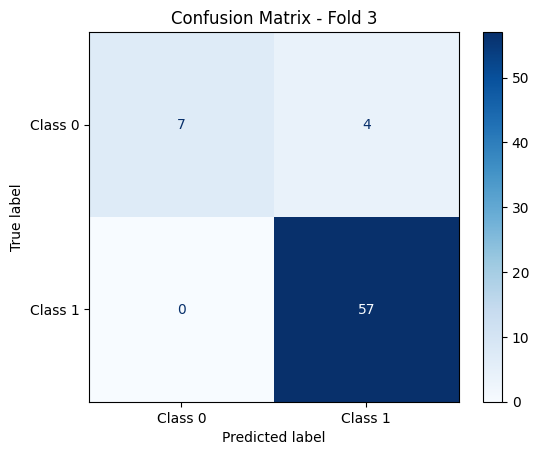

FOLD 4/5
Epoch [1/200], Train Loss: 0.5698, Val Loss: 0.4871, Train Acc: 0.3516, Val Acc: 0.5882
Epoch [2/200], Train Loss: 0.4642, Val Loss: 0.4009, Train Acc: 0.6886, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.4041, Val Loss: 0.3571, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.3757, Val Loss: 0.3338, Train Acc: 0.8608, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.3607, Val Loss: 0.3233, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.3388, Val Loss: 0.3110, Train Acc: 0.8718, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.3305, Val Loss: 0.3035, Train Acc: 0.8645, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.3159, Val Loss: 0.2974, Train Acc: 0.8608, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.3037, Val Loss: 0.2946, Train Acc: 0.8791, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.2976, Val Loss: 0.2906, Train Acc: 0.8901, Val Acc: 0.8971
Epoch [11/200], Train Loss: 0.2788, Val Loss: 0.2825, Train Acc: 0.9048, Val Acc: 0.9118
Epoch [12/200], Train

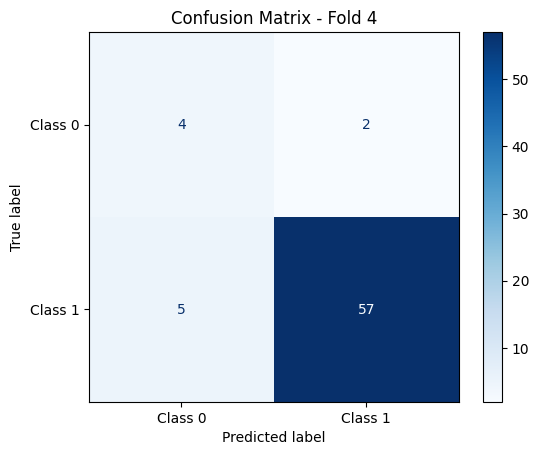

FOLD 5/5
Epoch [1/200], Train Loss: 0.4114, Val Loss: 0.3799, Train Acc: 0.8388, Val Acc: 0.8676
Epoch [2/200], Train Loss: 0.3848, Val Loss: 0.3548, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.3575, Val Loss: 0.3418, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.3481, Val Loss: 0.3344, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.3364, Val Loss: 0.3284, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.3315, Val Loss: 0.3215, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.3120, Val Loss: 0.3185, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3105, Val Loss: 0.3122, Train Acc: 0.8828, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.3160, Val Loss: 0.3079, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.2863, Val Loss: 0.2985, Train Acc: 0.8938, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.2848, Val Loss: 0.2885, Train Acc: 0.8791, Val Acc: 0.8971
Epoch [12/200], Train

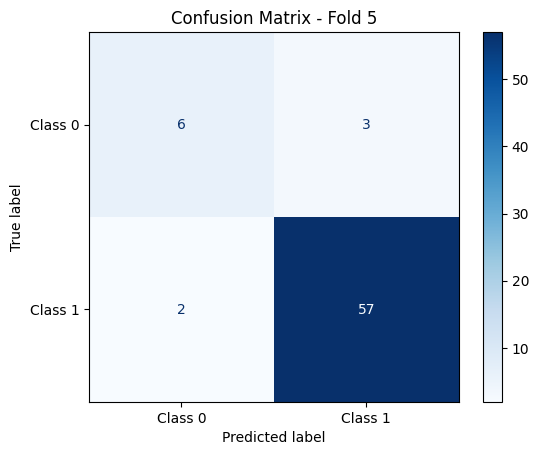


Average Validation Accuracy: 0.9295
Best Validation Accuracy: 0.9710
Completed Combination 7: Avg Val Accuracy = 0.9295

Hyperparameter Combination 8/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.7, 'weight_decay': 0.001, 'neg_weight': 1.2, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.6637, Val Loss: 0.5920, Train Acc: 0.1838, Val Acc: 0.1884
Epoch [2/200], Train Loss: 0.5428, Val Loss: 0.4740, Train Acc: 0.4338, Val Acc: 0.6957
Epoch [3/200], Train Loss: 0.4650, Val Loss: 0.4005, Train Acc: 0.7279, Val Acc: 0.8841
Epoch [4/200], Train Loss: 0.4255, Val Loss: 0.3614, Train Acc: 0.8272, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.3917, Val Loss: 0.3368, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.3814, Val Loss: 0.3202, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.3553, Val Loss: 0.3058, Train Acc: 0.8640, Val Acc: 0.9130
Epoch [8/200], Train Loss: 0.3483, Val Loss: 

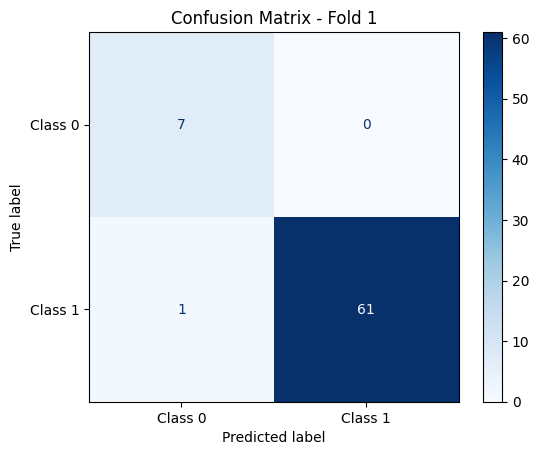

FOLD 2/5
Epoch [1/200], Train Loss: 0.4740, Val Loss: 0.4783, Train Acc: 0.6447, Val Acc: 0.7941
Epoch [2/200], Train Loss: 0.4165, Val Loss: 0.4506, Train Acc: 0.8425, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.3719, Val Loss: 0.4349, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.3472, Val Loss: 0.4274, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.3428, Val Loss: 0.4215, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.3230, Val Loss: 0.4149, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.3210, Val Loss: 0.4100, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.3076, Val Loss: 0.4083, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.2905, Val Loss: 0.4039, Train Acc: 0.8901, Val Acc: 0.8088
Epoch [10/200], Train Loss: 0.2889, Val Loss: 0.4020, Train Acc: 0.8864, Val Acc: 0.8088
Epoch [11/200], Train Loss: 0.2817, Val Loss: 0.3958, Train Acc: 0.8864, Val Acc: 0.8088
Epoch [12/200], Train

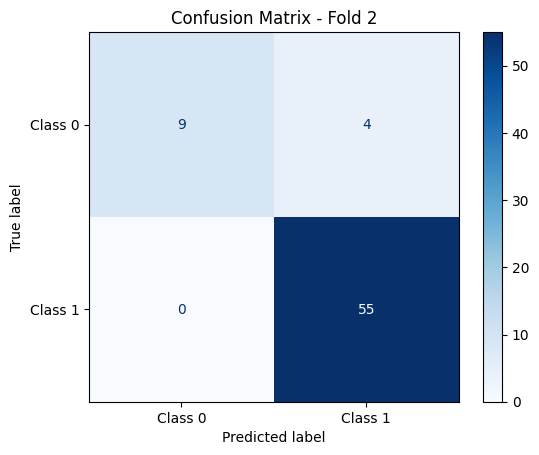

FOLD 3/5
Epoch [1/200], Train Loss: 0.4220, Val Loss: 0.4122, Train Acc: 0.8168, Val Acc: 0.8382
Epoch [2/200], Train Loss: 0.3867, Val Loss: 0.3918, Train Acc: 0.8608, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.3580, Val Loss: 0.3809, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.3501, Val Loss: 0.3715, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.3413, Val Loss: 0.3654, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.3310, Val Loss: 0.3603, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.3136, Val Loss: 0.3543, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.3073, Val Loss: 0.3468, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.3060, Val Loss: 0.3428, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2891, Val Loss: 0.3383, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.2910, Val Loss: 0.3308, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [12/200], Train

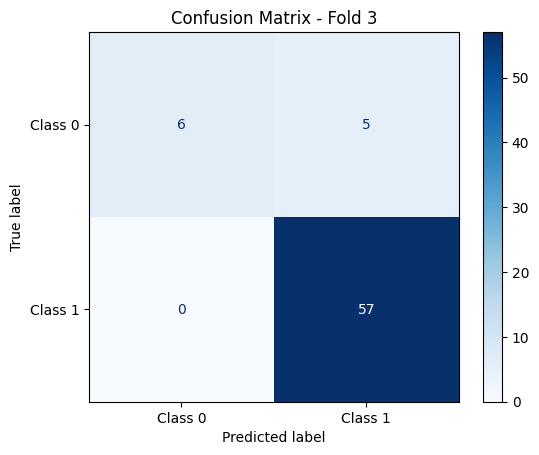

FOLD 4/5
Epoch [1/200], Train Loss: 0.4779, Val Loss: 0.3910, Train Acc: 0.7216, Val Acc: 0.9118
Epoch [2/200], Train Loss: 0.4298, Val Loss: 0.3543, Train Acc: 0.8205, Val Acc: 0.9118
Epoch [3/200], Train Loss: 0.4074, Val Loss: 0.3305, Train Acc: 0.8498, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.3835, Val Loss: 0.3196, Train Acc: 0.8498, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.3782, Val Loss: 0.3122, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.3580, Val Loss: 0.3018, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.3450, Val Loss: 0.2935, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.3455, Val Loss: 0.2847, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.3238, Val Loss: 0.2769, Train Acc: 0.8645, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.3261, Val Loss: 0.2738, Train Acc: 0.8645, Val Acc: 0.9118
Epoch [11/200], Train Loss: 0.3120, Val Loss: 0.2652, Train Acc: 0.8608, Val Acc: 0.9265
Epoch [12/200], Train

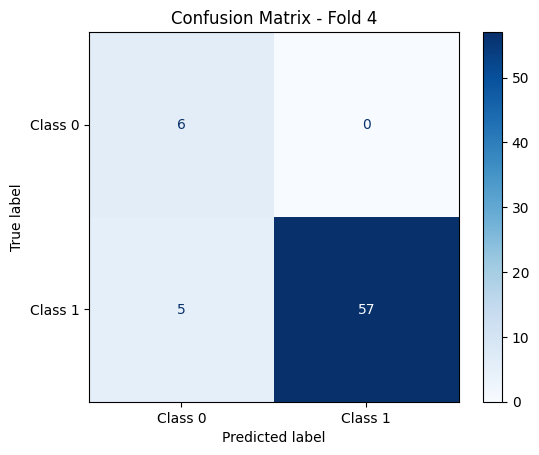

FOLD 5/5
Epoch [1/200], Train Loss: 0.4685, Val Loss: 0.4252, Train Acc: 0.7143, Val Acc: 0.8529
Epoch [2/200], Train Loss: 0.4163, Val Loss: 0.3940, Train Acc: 0.8535, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.3921, Val Loss: 0.3769, Train Acc: 0.8571, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.3773, Val Loss: 0.3658, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.3602, Val Loss: 0.3570, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.3523, Val Loss: 0.3478, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.3458, Val Loss: 0.3400, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3299, Val Loss: 0.3329, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.3258, Val Loss: 0.3270, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.3163, Val Loss: 0.3210, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.3016, Val Loss: 0.3148, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [12/200], Train

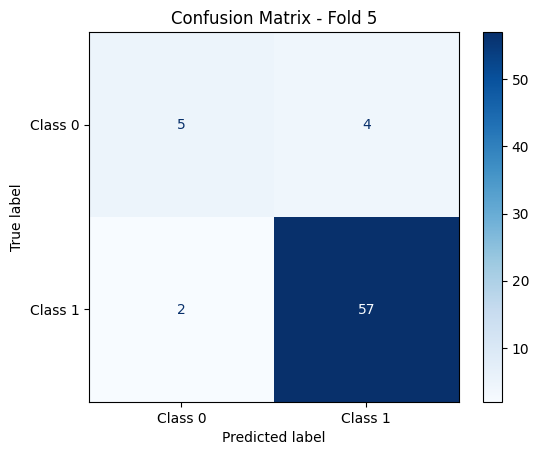


Average Validation Accuracy: 0.9383
Best Validation Accuracy: 0.9855
Completed Combination 8: Avg Val Accuracy = 0.9383

Hyperparameter Combination 9/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 0.7, 'weight_decay': 0.001, 'neg_weight': 3, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.5843, Val Loss: 0.5060, Train Acc: 0.3382, Val Acc: 0.5652
Epoch [2/200], Train Loss: 0.4984, Val Loss: 0.4178, Train Acc: 0.6324, Val Acc: 0.8551
Epoch [3/200], Train Loss: 0.4371, Val Loss: 0.3702, Train Acc: 0.8199, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.4010, Val Loss: 0.3440, Train Acc: 0.8603, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.3859, Val Loss: 0.3282, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.3733, Val Loss: 0.3167, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.3535, Val Loss: 0.3062, Train Acc: 0.8603, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.3531, Val Loss: 0.

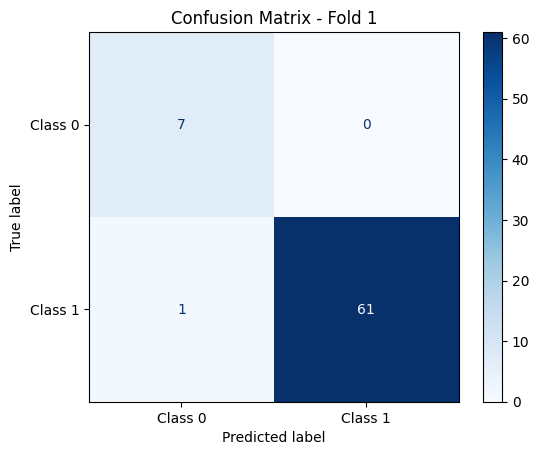

FOLD 2/5
Epoch [1/200], Train Loss: 0.4780, Val Loss: 0.4551, Train Acc: 0.6667, Val Acc: 0.7794
Epoch [2/200], Train Loss: 0.4048, Val Loss: 0.4287, Train Acc: 0.8462, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.3616, Val Loss: 0.4139, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.3351, Val Loss: 0.4075, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.3223, Val Loss: 0.4027, Train Acc: 0.8755, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.3092, Val Loss: 0.3979, Train Acc: 0.8901, Val Acc: 0.8235
Epoch [7/200], Train Loss: 0.2988, Val Loss: 0.3941, Train Acc: 0.8938, Val Acc: 0.8235
Epoch [8/200], Train Loss: 0.2869, Val Loss: 0.3921, Train Acc: 0.8974, Val Acc: 0.8235
Epoch [9/200], Train Loss: 0.2777, Val Loss: 0.3890, Train Acc: 0.9011, Val Acc: 0.8235
Epoch [10/200], Train Loss: 0.2753, Val Loss: 0.3850, Train Acc: 0.9048, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.2607, Val Loss: 0.3832, Train Acc: 0.9158, Val Acc: 0.8235
Epoch [12/200], Train

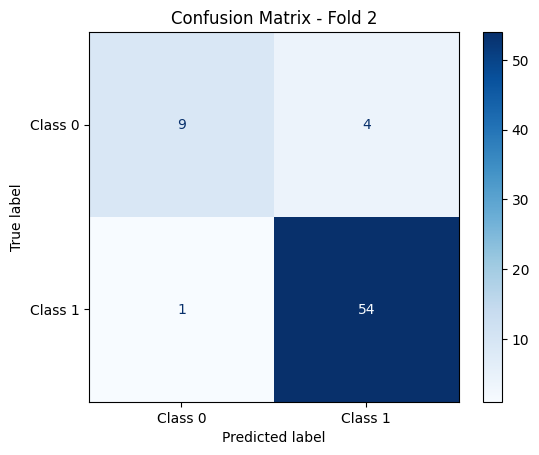

FOLD 3/5
Epoch [1/200], Train Loss: 0.4680, Val Loss: 0.4431, Train Acc: 0.7143, Val Acc: 0.8382
Epoch [2/200], Train Loss: 0.4026, Val Loss: 0.4101, Train Acc: 0.8571, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.3718, Val Loss: 0.3941, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.3553, Val Loss: 0.3843, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.3408, Val Loss: 0.3750, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.3292, Val Loss: 0.3676, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.3285, Val Loss: 0.3577, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.3169, Val Loss: 0.3498, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.3055, Val Loss: 0.3438, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.2994, Val Loss: 0.3381, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.2901, Val Loss: 0.3299, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [12/200], Train

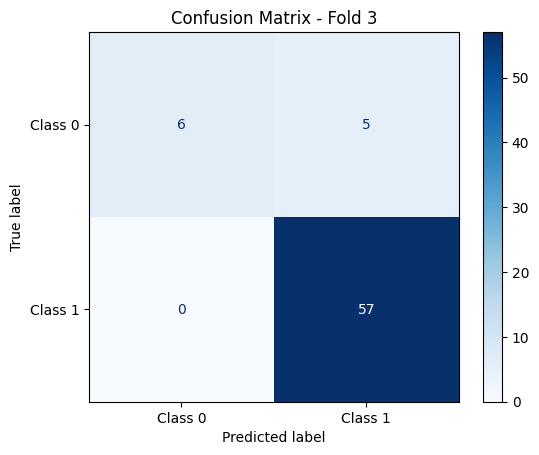

FOLD 4/5
Epoch [1/200], Train Loss: 0.5766, Val Loss: 0.4811, Train Acc: 0.3590, Val Acc: 0.6029
Epoch [2/200], Train Loss: 0.4720, Val Loss: 0.3958, Train Acc: 0.6960, Val Acc: 0.8824
Epoch [3/200], Train Loss: 0.4196, Val Loss: 0.3515, Train Acc: 0.8168, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.3903, Val Loss: 0.3262, Train Acc: 0.8462, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.3697, Val Loss: 0.3099, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.3592, Val Loss: 0.2977, Train Acc: 0.8718, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.3499, Val Loss: 0.2889, Train Acc: 0.8681, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.3360, Val Loss: 0.2819, Train Acc: 0.8681, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.3278, Val Loss: 0.2744, Train Acc: 0.8755, Val Acc: 0.9265
Epoch [10/200], Train Loss: 0.3201, Val Loss: 0.2720, Train Acc: 0.8755, Val Acc: 0.9559
Epoch [11/200], Train Loss: 0.3063, Val Loss: 0.2673, Train Acc: 0.8864, Val Acc: 0.9412
Epoch [12/200], Train

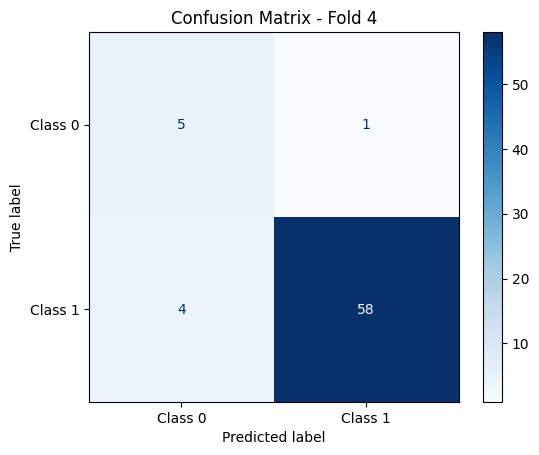

FOLD 5/5
Epoch [1/200], Train Loss: 0.4655, Val Loss: 0.4230, Train Acc: 0.7070, Val Acc: 0.8529
Epoch [2/200], Train Loss: 0.4123, Val Loss: 0.3895, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.3811, Val Loss: 0.3694, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.3669, Val Loss: 0.3587, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.3462, Val Loss: 0.3488, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.3403, Val Loss: 0.3409, Train Acc: 0.8828, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.3353, Val Loss: 0.3338, Train Acc: 0.8791, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3194, Val Loss: 0.3274, Train Acc: 0.8755, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.3089, Val Loss: 0.3196, Train Acc: 0.8828, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.3034, Val Loss: 0.3128, Train Acc: 0.8828, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.2928, Val Loss: 0.3050, Train Acc: 0.8938, Val Acc: 0.8824
Epoch [12/200], Train

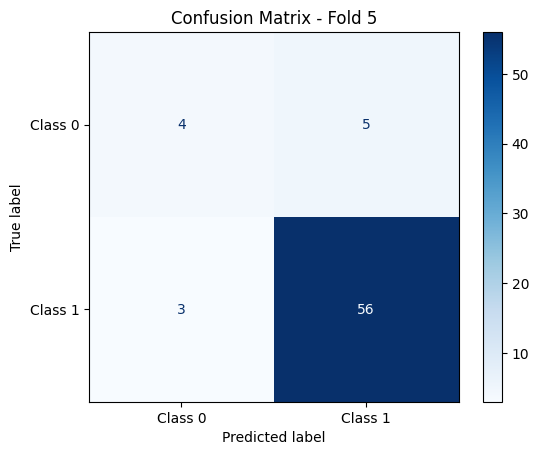


Average Validation Accuracy: 0.9295
Best Validation Accuracy: 0.9855
Completed Combination 9: Avg Val Accuracy = 0.9295

Hyperparameter Combination 10/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 1.0, 'weight_decay': 0.001, 'neg_weight': 1.1, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.6878, Val Loss: 0.6149, Train Acc: 0.5478, Val Acc: 0.8116
Epoch [2/200], Train Loss: 0.5840, Val Loss: 0.5090, Train Acc: 0.8199, Val Acc: 0.8841
Epoch [3/200], Train Loss: 0.5048, Val Loss: 0.4496, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.4723, Val Loss: 0.4133, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.4497, Val Loss: 0.3954, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.4336, Val Loss: 0.3825, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.4221, Val Loss: 0.3715, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.4118, Val Loss:

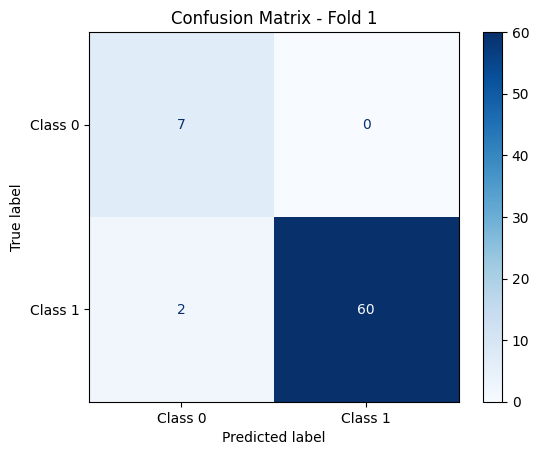

FOLD 2/5
Epoch [1/200], Train Loss: 0.4834, Val Loss: 0.5126, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [2/200], Train Loss: 0.4403, Val Loss: 0.4973, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.4206, Val Loss: 0.4879, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.4046, Val Loss: 0.4819, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.3866, Val Loss: 0.4770, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.3753, Val Loss: 0.4718, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.3602, Val Loss: 0.4661, Train Acc: 0.8901, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.3563, Val Loss: 0.4608, Train Acc: 0.8938, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.3430, Val Loss: 0.4571, Train Acc: 0.9011, Val Acc: 0.8235
Epoch [10/200], Train Loss: 0.3288, Val Loss: 0.4540, Train Acc: 0.9048, Val Acc: 0.8235
Epoch [11/200], Train Loss: 0.3217, Val Loss: 0.4503, Train Acc: 0.9084, Val Acc: 0.8235
Epoch [12/200], Train

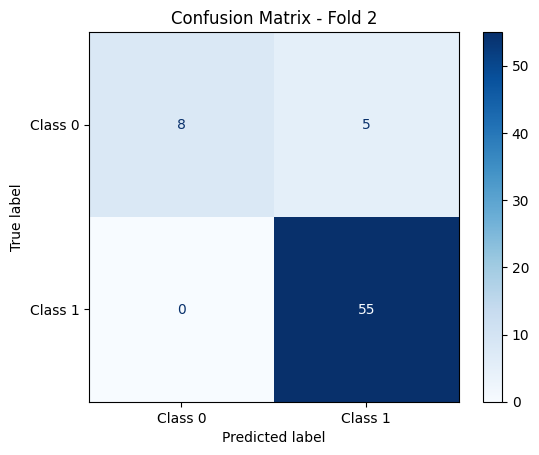

FOLD 3/5
Epoch [1/200], Train Loss: 0.8436, Val Loss: 0.7553, Train Acc: 0.2674, Val Acc: 0.3676
Epoch [2/200], Train Loss: 0.6967, Val Loss: 0.6325, Train Acc: 0.5165, Val Acc: 0.7059
Epoch [3/200], Train Loss: 0.5879, Val Loss: 0.5641, Train Acc: 0.7546, Val Acc: 0.8235
Epoch [4/200], Train Loss: 0.5203, Val Loss: 0.5193, Train Acc: 0.8608, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.4751, Val Loss: 0.4948, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.4357, Val Loss: 0.4757, Train Acc: 0.8828, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.4278, Val Loss: 0.4621, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.4086, Val Loss: 0.4525, Train Acc: 0.8828, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.3932, Val Loss: 0.4461, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.3820, Val Loss: 0.4372, Train Acc: 0.8864, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.3652, Val Loss: 0.4293, Train Acc: 0.8938, Val Acc: 0.8382
Epoch [12/200], Train

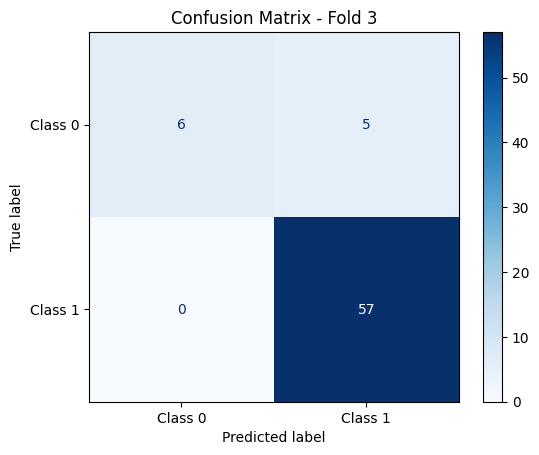

FOLD 4/5
Epoch [1/200], Train Loss: 0.6889, Val Loss: 0.6266, Train Acc: 0.5568, Val Acc: 0.7647
Epoch [2/200], Train Loss: 0.6120, Val Loss: 0.5517, Train Acc: 0.7656, Val Acc: 0.8971
Epoch [3/200], Train Loss: 0.5658, Val Loss: 0.4987, Train Acc: 0.8352, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.5185, Val Loss: 0.4595, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.4843, Val Loss: 0.4283, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.4689, Val Loss: 0.4041, Train Acc: 0.8498, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.4549, Val Loss: 0.3916, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.4373, Val Loss: 0.3764, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.4182, Val Loss: 0.3624, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.4086, Val Loss: 0.3514, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [11/200], Train Loss: 0.3956, Val Loss: 0.3415, Train Acc: 0.8608, Val Acc: 0.9265
Epoch [12/200], Train

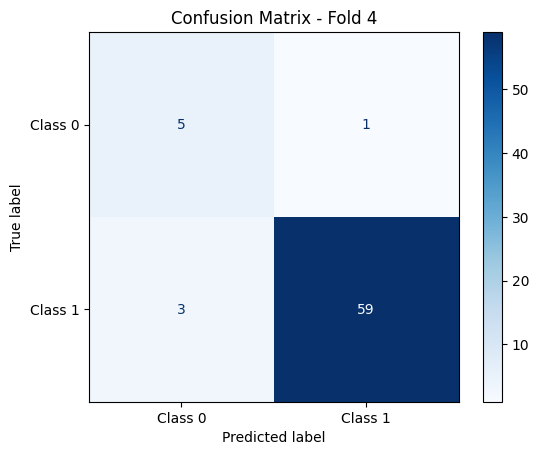

FOLD 5/5
Epoch [1/200], Train Loss: 0.6681, Val Loss: 0.5708, Train Acc: 0.5678, Val Acc: 0.8676
Epoch [2/200], Train Loss: 0.5633, Val Loss: 0.4965, Train Acc: 0.8168, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.5051, Val Loss: 0.4513, Train Acc: 0.8571, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.4519, Val Loss: 0.4244, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.4329, Val Loss: 0.4077, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.4170, Val Loss: 0.3943, Train Acc: 0.8608, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.3974, Val Loss: 0.3848, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3815, Val Loss: 0.3768, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.3800, Val Loss: 0.3695, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.3702, Val Loss: 0.3632, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.3611, Val Loss: 0.3575, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [12/200], Train

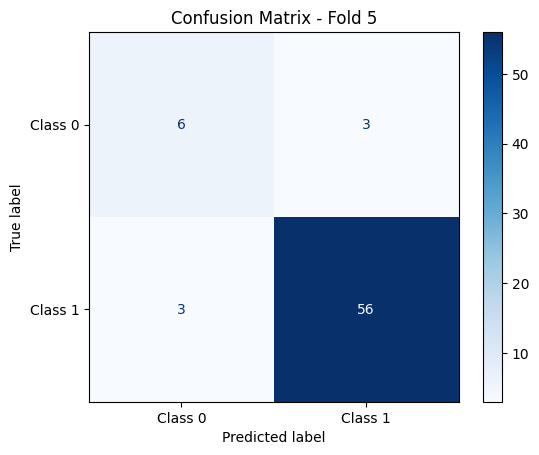


Average Validation Accuracy: 0.9354
Best Validation Accuracy: 0.9710
Completed Combination 10: Avg Val Accuracy = 0.9354

Hyperparameter Combination 11/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 1.0, 'weight_decay': 0.001, 'neg_weight': 1.2, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.6225, Val Loss: 0.5314, Train Acc: 0.7059, Val Acc: 0.8986
Epoch [2/200], Train Loss: 0.5354, Val Loss: 0.4648, Train Acc: 0.8419, Val Acc: 0.8986
Epoch [3/200], Train Loss: 0.4925, Val Loss: 0.4247, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.4700, Val Loss: 0.4010, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.4499, Val Loss: 0.3840, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.4300, Val Loss: 0.3712, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.4164, Val Loss: 0.3584, Train Acc: 0.8603, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.4116, Val Loss

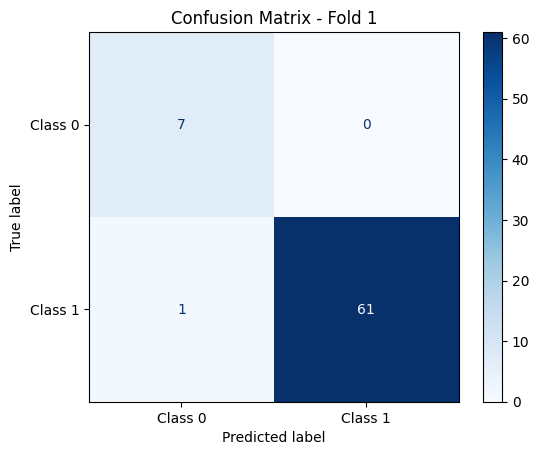

FOLD 2/5
Epoch [1/200], Train Loss: 0.6557, Val Loss: 0.6002, Train Acc: 0.6264, Val Acc: 0.7206
Epoch [2/200], Train Loss: 0.5373, Val Loss: 0.5265, Train Acc: 0.8608, Val Acc: 0.8235
Epoch [3/200], Train Loss: 0.4628, Val Loss: 0.4963, Train Acc: 0.8828, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.4384, Val Loss: 0.4825, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.3980, Val Loss: 0.4746, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.3913, Val Loss: 0.4696, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.3841, Val Loss: 0.4654, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.3705, Val Loss: 0.4622, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.3537, Val Loss: 0.4570, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [10/200], Train Loss: 0.3437, Val Loss: 0.4525, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [11/200], Train Loss: 0.3288, Val Loss: 0.4482, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [12/200], Train

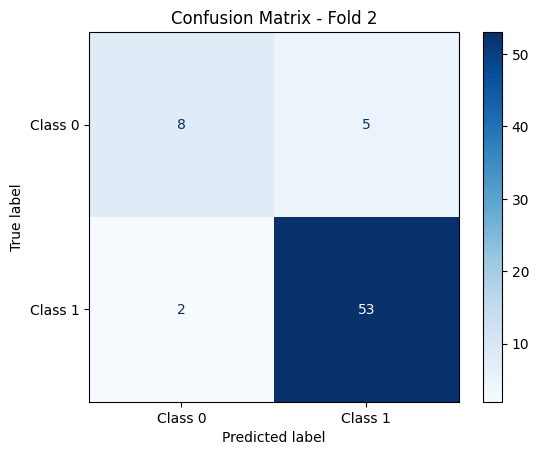

FOLD 3/5
Epoch [1/200], Train Loss: 0.5717, Val Loss: 0.5181, Train Acc: 0.7656, Val Acc: 0.8382
Epoch [2/200], Train Loss: 0.4653, Val Loss: 0.4679, Train Acc: 0.8645, Val Acc: 0.8382
Epoch [3/200], Train Loss: 0.4235, Val Loss: 0.4483, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.3950, Val Loss: 0.4340, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.3942, Val Loss: 0.4253, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.3798, Val Loss: 0.4174, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.3577, Val Loss: 0.4090, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.3437, Val Loss: 0.4010, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.3362, Val Loss: 0.3913, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.3230, Val Loss: 0.3795, Train Acc: 0.8791, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.3068, Val Loss: 0.3673, Train Acc: 0.8901, Val Acc: 0.8382
Epoch [12/200], Train

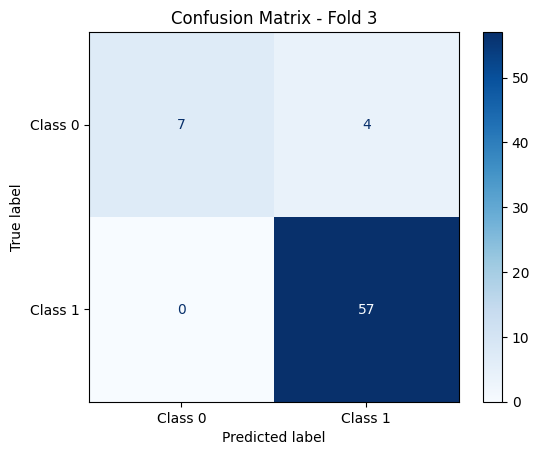

FOLD 4/5
Epoch [1/200], Train Loss: 0.5730, Val Loss: 0.4920, Train Acc: 0.8205, Val Acc: 0.9118
Epoch [2/200], Train Loss: 0.5010, Val Loss: 0.4267, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [3/200], Train Loss: 0.4584, Val Loss: 0.3880, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.4414, Val Loss: 0.3695, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.4131, Val Loss: 0.3572, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.4035, Val Loss: 0.3431, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.4004, Val Loss: 0.3324, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.3910, Val Loss: 0.3247, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.3788, Val Loss: 0.3195, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.3724, Val Loss: 0.3128, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [11/200], Train Loss: 0.3544, Val Loss: 0.3076, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [12/200], Train

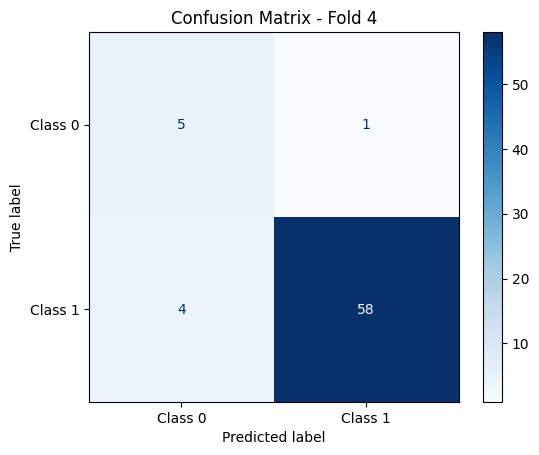

FOLD 5/5
Epoch [1/200], Train Loss: 0.5679, Val Loss: 0.5122, Train Acc: 0.8205, Val Acc: 0.8529
Epoch [2/200], Train Loss: 0.4918, Val Loss: 0.4644, Train Acc: 0.8608, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.4513, Val Loss: 0.4470, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.4483, Val Loss: 0.4336, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.4291, Val Loss: 0.4206, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.4113, Val Loss: 0.4106, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.4038, Val Loss: 0.4059, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3918, Val Loss: 0.3984, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.3732, Val Loss: 0.3932, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.3682, Val Loss: 0.3881, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.3518, Val Loss: 0.3810, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [12/200], Train

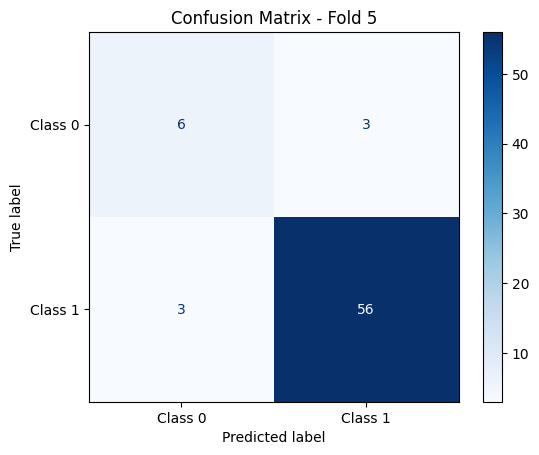


Average Validation Accuracy: 0.9324
Best Validation Accuracy: 0.9855
Completed Combination 11: Avg Val Accuracy = 0.9324

Hyperparameter Combination 12/12: {'num_epochs': 200, 'batch_size': 16, 'learning_rate': 0.0001, 'hidden_dim': 64, 'pos_weight': 1.0, 'weight_decay': 0.001, 'neg_weight': 3, 'augment_minority_class': False}
FOLD 1/5
Epoch [1/200], Train Loss: 0.8690, Val Loss: 0.7608, Train Acc: 0.2500, Val Acc: 0.3188
Epoch [2/200], Train Loss: 0.6880, Val Loss: 0.6113, Train Acc: 0.5551, Val Acc: 0.7971
Epoch [3/200], Train Loss: 0.5797, Val Loss: 0.5224, Train Acc: 0.7904, Val Acc: 0.8986
Epoch [4/200], Train Loss: 0.5179, Val Loss: 0.4630, Train Acc: 0.8529, Val Acc: 0.8986
Epoch [5/200], Train Loss: 0.4807, Val Loss: 0.4231, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [6/200], Train Loss: 0.4463, Val Loss: 0.3965, Train Acc: 0.8566, Val Acc: 0.8986
Epoch [7/200], Train Loss: 0.4184, Val Loss: 0.3764, Train Acc: 0.8640, Val Acc: 0.8986
Epoch [8/200], Train Loss: 0.4163, Val Loss: 

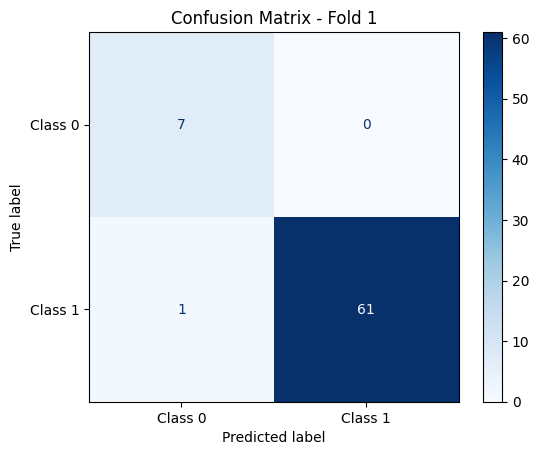

FOLD 2/5
Epoch [1/200], Train Loss: 0.6102, Val Loss: 0.6001, Train Acc: 0.7326, Val Acc: 0.7941
Epoch [2/200], Train Loss: 0.5199, Val Loss: 0.5441, Train Acc: 0.8571, Val Acc: 0.8088
Epoch [3/200], Train Loss: 0.4544, Val Loss: 0.5148, Train Acc: 0.8718, Val Acc: 0.8088
Epoch [4/200], Train Loss: 0.4289, Val Loss: 0.4979, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [5/200], Train Loss: 0.4047, Val Loss: 0.4858, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [6/200], Train Loss: 0.3880, Val Loss: 0.4789, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [7/200], Train Loss: 0.3687, Val Loss: 0.4715, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [8/200], Train Loss: 0.3589, Val Loss: 0.4643, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [9/200], Train Loss: 0.3382, Val Loss: 0.4626, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [10/200], Train Loss: 0.3314, Val Loss: 0.4569, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [11/200], Train Loss: 0.3241, Val Loss: 0.4507, Train Acc: 0.8791, Val Acc: 0.8088
Epoch [12/200], Train

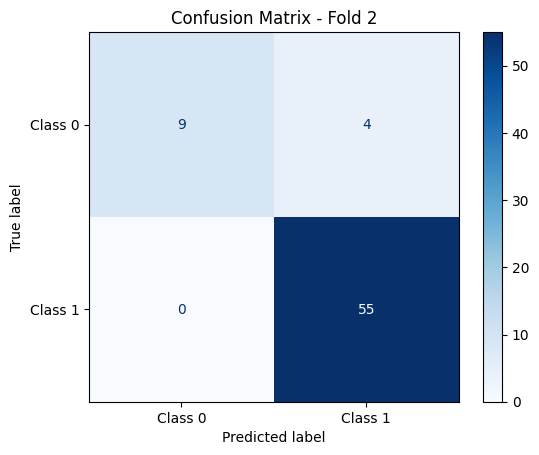

FOLD 3/5
Epoch [1/200], Train Loss: 0.8460, Val Loss: 0.6976, Train Acc: 0.2271, Val Acc: 0.4559
Epoch [2/200], Train Loss: 0.6768, Val Loss: 0.5963, Train Acc: 0.5934, Val Acc: 0.8235
Epoch [3/200], Train Loss: 0.5844, Val Loss: 0.5435, Train Acc: 0.8095, Val Acc: 0.8382
Epoch [4/200], Train Loss: 0.5245, Val Loss: 0.5137, Train Acc: 0.8608, Val Acc: 0.8382
Epoch [5/200], Train Loss: 0.4956, Val Loss: 0.4943, Train Acc: 0.8681, Val Acc: 0.8382
Epoch [6/200], Train Loss: 0.4884, Val Loss: 0.4806, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [7/200], Train Loss: 0.4614, Val Loss: 0.4722, Train Acc: 0.8755, Val Acc: 0.8382
Epoch [8/200], Train Loss: 0.4462, Val Loss: 0.4641, Train Acc: 0.8718, Val Acc: 0.8382
Epoch [9/200], Train Loss: 0.4348, Val Loss: 0.4559, Train Acc: 0.8681, Val Acc: 0.8382
Epoch [10/200], Train Loss: 0.4176, Val Loss: 0.4502, Train Acc: 0.8864, Val Acc: 0.8382
Epoch [11/200], Train Loss: 0.4172, Val Loss: 0.4442, Train Acc: 0.8828, Val Acc: 0.8382
Epoch [12/200], Train

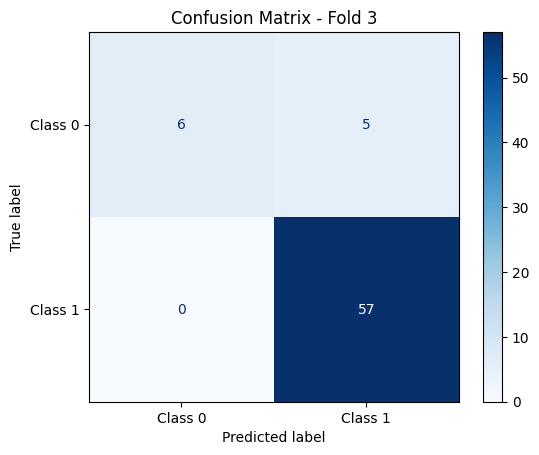

FOLD 4/5
Epoch [1/200], Train Loss: 0.6450, Val Loss: 0.5716, Train Acc: 0.6996, Val Acc: 0.8529
Epoch [2/200], Train Loss: 0.5465, Val Loss: 0.4954, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [3/200], Train Loss: 0.5012, Val Loss: 0.4456, Train Acc: 0.8571, Val Acc: 0.9118
Epoch [4/200], Train Loss: 0.4666, Val Loss: 0.4169, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [5/200], Train Loss: 0.4425, Val Loss: 0.3938, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [6/200], Train Loss: 0.4345, Val Loss: 0.3773, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [7/200], Train Loss: 0.4161, Val Loss: 0.3660, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [8/200], Train Loss: 0.4062, Val Loss: 0.3549, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [9/200], Train Loss: 0.3977, Val Loss: 0.3444, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [10/200], Train Loss: 0.3875, Val Loss: 0.3363, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [11/200], Train Loss: 0.3729, Val Loss: 0.3267, Train Acc: 0.8535, Val Acc: 0.9118
Epoch [12/200], Train

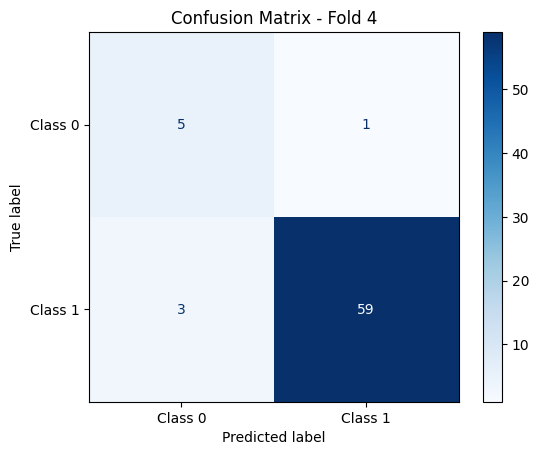

FOLD 5/5
Epoch [1/200], Train Loss: 0.6704, Val Loss: 0.6078, Train Acc: 0.5824, Val Acc: 0.8529
Epoch [2/200], Train Loss: 0.5785, Val Loss: 0.5342, Train Acc: 0.8388, Val Acc: 0.8676
Epoch [3/200], Train Loss: 0.5147, Val Loss: 0.4882, Train Acc: 0.8718, Val Acc: 0.8676
Epoch [4/200], Train Loss: 0.4835, Val Loss: 0.4598, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [5/200], Train Loss: 0.4524, Val Loss: 0.4382, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [6/200], Train Loss: 0.4294, Val Loss: 0.4253, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [7/200], Train Loss: 0.4190, Val Loss: 0.4140, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [8/200], Train Loss: 0.3985, Val Loss: 0.4046, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [9/200], Train Loss: 0.3870, Val Loss: 0.3989, Train Acc: 0.8645, Val Acc: 0.8676
Epoch [10/200], Train Loss: 0.3739, Val Loss: 0.3900, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [11/200], Train Loss: 0.3731, Val Loss: 0.3818, Train Acc: 0.8681, Val Acc: 0.8676
Epoch [12/200], Train

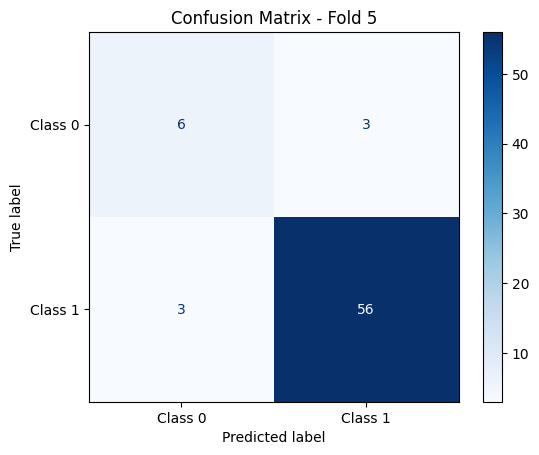


Average Validation Accuracy: 0.9412
Best Validation Accuracy: 0.9855
Completed Combination 12: Avg Val Accuracy = 0.9412


In [12]:
# Initialize a list to store results
tuning_results = []

# Iterate over each hyperparameter combination
for idx, params in enumerate(hyperparameter_combinations, 1):
    print(f"\nHyperparameter Combination {idx}/{len(hyperparameter_combinations)}: {params}")

    # Extract hyperparameters
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    hidden_dim = params['hidden_dim']
    pos_weight = params['pos_weight']
    weight_decay = params['weight_decay']
    augment_minority_class = params['augment_minority_class']

    # Train and evaluate the model with the current set of hyperparameters
    try:
        best_model_state, train_losses, val_losses, train_accuracies, val_accuracies, avg_val_accuracy = train_and_evaluate_model(
            dataset=dataset_iso,
            device=device,
            model_class=MLPBinaryClassifier,
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            pos_weight=pos_weight,
            neg_weight=1.0,  # Assuming neg_weight remains constant; adjust if needed
            k_folds=5,
            hidden_dim=hidden_dim,
            augment_minority_class=augment_minority_class,
            weight_decay=weight_decay
        )

        # Store the results
        tuning_results.append({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'hidden_dim': hidden_dim,
            'pos_weight': pos_weight,
            'weight_decay': weight_decay,
            'augment_minority_class': augment_minority_class,
            'avg_val_accuracy': avg_val_accuracy
        })

        print(f"Completed Combination {idx}: Avg Val Accuracy = {avg_val_accuracy:.4f}")

    except Exception as e:
        print(f"Error with Combination {idx}: {params}")
        print(e)
        continue


In [13]:
# Convert the results to a DataFrame for easier analysis
results_df = pd.DataFrame(tuning_results)

# Sort the results by average validation accuracy in descending order
results_df = results_df.sort_values(by='avg_val_accuracy', ascending=False)

# Display the top 5 hyperparameter combinations
print("\nTop 5 Hyperparameter Combinations:")
print(results_df.head(5))
results_df.to_csv('/content/drive/My Drive/Disorder/Model_Config/experiments.csv')


Top 5 Hyperparameter Combinations:
    num_epochs  batch_size  learning_rate  hidden_dim  pos_weight  \
0          200          16         0.0001          64         0.5   
11         200          16         0.0001          64         1.0   
4          200          16         0.0001          64         0.6   
7          200          16         0.0001          64         0.7   
5          200          16         0.0001          64         0.6   

    weight_decay  augment_minority_class  avg_val_accuracy  
0          0.001                   False          0.944203  
11         0.001                   False          0.941219  
4          0.001                   False          0.938321  
7          0.001                   False          0.938278  
5          0.001                   False          0.938278  


In [10]:
# Convert the results to a DataFrame for easier analysis

# Sort the results by average validation accuracy in descending order
#results_df = results_df.sort_values(by='avg_val_accuracy', ascending=False)

# Display the top 5 hyperparameter combinations
print("\nTop 5 Hyperparameter Combinations:")
print(results_df.head(5))
news = '/content/drive/My Drive/Disorder/Model_Config/experiments.csv'
# Save the DataFrame to a CSV file in your project drive
results_df.to_csv(news, index=False)


Top 5 Hyperparameter Combinations:
                        ID    REP_Q2    REP_N2    REP_S2    REP_G2    REP_E2  \
0  ABRAXAS1-Q6UWZ7-121-200 -0.387436 -0.369605 -0.042491 -0.545608 -0.649255   
1       AHR-P35869-531-720  6.502046 -0.369605 -0.042491 -0.545608 -0.649255   
2        AKAP8-O43823-1-80 -0.387436 -0.369605 -0.737793  1.577840 -0.649255   
3       AKAP8L-Q9ULX6-1-80 -0.387436 -0.369605 -0.042491 -0.545608 -0.649255   
4     APBB1-O00213-221-330 -0.387436 -0.369605  0.652811 -0.545608  0.039929   

     REP_D2    REP_K2    REP_R2    REP_P2  ...  net_charge  WF_complexity  \
0 -0.479691 -0.611583 -0.551053 -0.586244  ...    0.357382      -0.121465   
1 -0.479691 -0.611583 -0.551053 -0.586244  ...   -1.405510       1.404268   
2 -0.479691 -0.611583 -0.551053 -0.586244  ...   -0.112723      -2.302088   
3 -0.479691 -0.611583 -0.551053 -0.586244  ...   -0.465301      -1.807676   
4 -0.479691 -0.611583 -0.551053  0.178026  ...   -1.758089      -0.104256   

   KL_hydropathy  is